In [53]:
# importing all necessary libraries

import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Data Preprocessing and Visualization

## transactions dataset preprocessing

In [54]:
# Reading transactions data
transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
transactions

date  store_nbr  transactions
0      2013-01-01         25           770
1      2013-01-02          1          2111
2      2013-01-02          2          2358
3      2013-01-02          3          3487
4      2013-01-02          4          1922
...           ...        ...           ...
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802

[83488 rows x 3 columns]

As we can see above, transactions columns shows total number of transactions of the store for the day.
It doesn't have transactions of the store for each family of the product for the day.
So, we will combine "date" and "store_nbr" column which will act as groupby.

In [55]:
# Creating new column consist of "date" + "store_nbr" column for merging this dataset to sales data
transactions["date_stn"] = transactions.apply(lambda x: x[0] + str(x[1]), axis=1)

# Dropping "date" and "store_nbr" column beacuse those wont be useful 
transactions.drop(columns=["date", "store_nbr"], axis=1, inplace=True)
transactions

transactions      date_stn
0               770  2013-01-0125
1              2111   2013-01-021
2              2358   2013-01-022
3              3487   2013-01-023
4              1922   2013-01-024
...             ...           ...
83483          2804  2017-08-1550
83484          1573  2017-08-1551
83485          2255  2017-08-1552
83486           932  2017-08-1553
83487           802  2017-08-1554

[83488 rows x 2 columns]

In [56]:
# Reading sales training data and merging it with transactions dataset
data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")

# creating "date_stn" column as before for merging 
data["date_stn"] = data.apply(lambda x: x[1] + str(x[2]), axis=1)
data

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion     date_stn  
0                  0  2013-01-011  
1                  0  2013-01-011  
2                  0  2013-01-011  
3                  0  2013-01-011  
4                  0  2013-01-011  
...              ...          ...  
3000883            0  2017-08-159  
3000884            1  2017-08-159  
3000885          148  2017-08-159  
3000886            8  2017-08-159  
3000887            0  2017-08-159  

[3000888 rows x 7 columns]

In [57]:
# Merging transactions and sales data on "date_stn"
data1 = data.merge(transactions, how="left", on="date_stn").copy()
data1

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion     date_stn  transactions  
0                  0  2013-01-011           NaN  
1                  0  2013-01-011           NaN  
2                  0  2013-01-011           NaN  
3                  0  2013-01-011           NaN  
4                  0  2013-01-011           NaN  
...              ...          ...           ...  
3000883            0  2017-08-159        2155.0  
3000884            1  2017-08-159        2155.0  
3000885          148  2017-08-159        2155.0  
3000886            8  2017-08-159        2155.0  
3000887            0  2017-08-159        2155.0  

[3000888 rows x 8 columns]

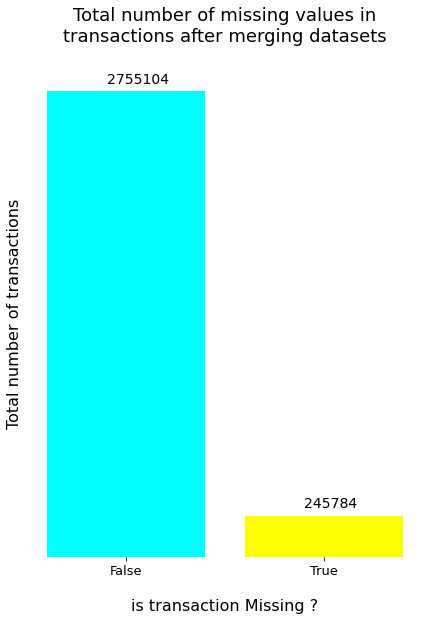

In [58]:
def plot_missing_transactions(data1):
    
    missing_transactions = dict(data1["transactions"].isna().value_counts())
    mt = {"False":missing_transactions[False], "True":missing_transactions[True]}
    
    plt.figure(figsize=(7,9))
    plt.bar(x = mt.keys(), height = mt.values(), color = ["#00ffff", "#ffff00"])
    
    plt.ylabel("Total number of transactions", size=16)
    plt.xlabel("\nis transaction Missing ?", size=16)
    
    plt.xticks(size=13)
    plt.yticks(size=13)
    
    plt.title("Total number of missing values in\ntransactions after merging datasets\n", size=18)
    plt.annotate(f"{missing_transactions[False]}", (False-0.1, missing_transactions[False]+50000), size=14)
    plt.annotate(f"{missing_transactions[True]}", (True-0.1, missing_transactions[True]+50000), size=14)
    
    plt.yticks([])
    plt.box(False)

plot_missing_transactions(data1.copy())

There are 245784 missing values out of 2755104

And as we can see below 242536 out of 245784 transactions missing values have sales 0

So, If we think logically whenever sales are 0 transactions are going to be 0 as well. So we will replace those missing values with sales 0 with 0.

and we subtract 242536 from 245784, we will get true missing values which are only 3248. Those are not too much so we will drop them.

In [59]:
# Total number of missing transaction w.r.t sales
data1[data1["transactions"].isna() == True]["sales"].value_counts()

0.000       242536
1.000          160
2.000          146
3.000          103
4.000           83
             ...  
647.117          1
1230.000         1
1891.000         1
934.000          1
41.689           1
Name: sales, Length: 1541, dtype: int64

In [60]:
# At first we will drop all 3248 rows which dont have sales 0 and are missing in transactions
transc_drop_idx = data1[(data1["transactions"].isna() == True) & (data["sales"] != 0)].index
data1.drop(labels=transc_drop_idx, axis=0, inplace=True)

# and we will fill rest with 0 since those have 0 sales
data1["transactions"].fillna(0, inplace=True)
data1

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion     date_stn  transactions  
0                  0  2013-01-011           0.0  
1                  0  2013-01-011           0.0  
2                  0  2013-01-011           0.0  
3                  0  2013-01-011           0.0  
4                  0  2013-01-011           0.0  
...              ...          ...           ...  
3000883            0  2017-08-159        2155.0  
3000884            1  2017-08-159        2155.0  
3000885          148  2017-08-159        2155.0  
3000886            8  2017-08-159        2155.0  
3000887            0  2017-08-159        2155.0  

[2997640 rows x 8 columns]

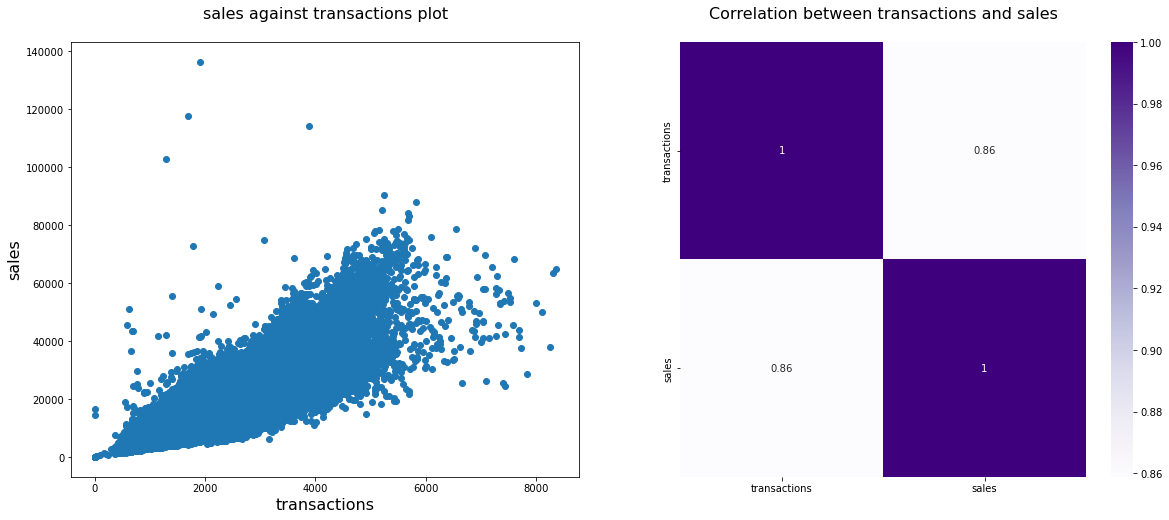

In [61]:
def plot_sales_transactions(data):
    data = data.groupby(["date","store_nbr"])
    Trsc = data.mean()["transactions"]
    Sles = data.sum()["sales"]
    TnS = pd.concat([Trsc, Sles], axis=1)

    plt.figure(figsize=(20,8))
    left = plt.subplot(1,2,1)
    plt.scatter(x = TnS["transactions"], y = TnS["sales"])
    plt.xlabel("transactions", size=16)
    plt.ylabel("sales", size=16)
    left.set_title("sales against transactions plot\n", size=16)

    right = plt.subplot(1,2,2)
    sns.heatmap(TnS.corr(), annot=TnS.corr(), cmap="Purples")
    right.set_title("Correlation between transactions and sales\n", size=16)

plot_sales_transactions(data1.copy())

As we can see there is positive correlation between "transactions" and "sales" 

But we can't use "transactions" column for prediction because we will be predicting future sales of the stores, transactions won't be available either.

So, we will not use "transactions" for prediction of sales.

## oil dataset preparation

In [62]:
# reading oil prices data 
oil_prices = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
oil_prices["date"] = pd.to_datetime(oil_prices["date"])
oil_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


As we can see above there are some missing values in oil prices column we will fill those using KNN Imputer

In [63]:
def get_cleaned_oil_data(oil_prices):
    
    # creating new time features for Imputing missing values
    oil_prices["day"] = oil_prices["date"].map(lambda x: x.day)
    oil_prices["month"] = oil_prices["date"].map(lambda x: x.month)
    oil_prices["year"] = oil_prices["date"].map(lambda x: x.year)
    oil_prices["yearmonthday"] = oil_prices.apply(lambda x: x[-1]*10000+x[-2]*100 + x[-3], axis=1)
    
    # Imputing missing oil prices with knn imputer
    imputer = KNNImputer(n_neighbors=2)
    prices = imputer.fit_transform(oil_prices.iloc[:,1:])
    
    oil_prices["dcoilwtico"] = prices[:,0]
    oil_prices.drop(columns = ["day", "month", "year"], axis = 1, inplace = True)
    
    return oil_prices

oil_prices = get_cleaned_oil_data(oil_prices)
oil_prices

date  dcoilwtico  yearmonthday
0    2013-01-01      93.055      20130101
1    2013-01-02      93.140      20130102
2    2013-01-03      92.970      20130103
3    2013-01-04      93.120      20130104
4    2013-01-07      93.200      20130107
...         ...         ...           ...
1213 2017-08-25      47.650      20170825
1214 2017-08-28      46.400      20170828
1215 2017-08-29      46.460      20170829
1216 2017-08-30      45.960      20170830
1217 2017-08-31      47.260      20170831

[1218 rows x 3 columns]

We filled missing values but there are still lot of missing days in oil dataset.

We will find those using below

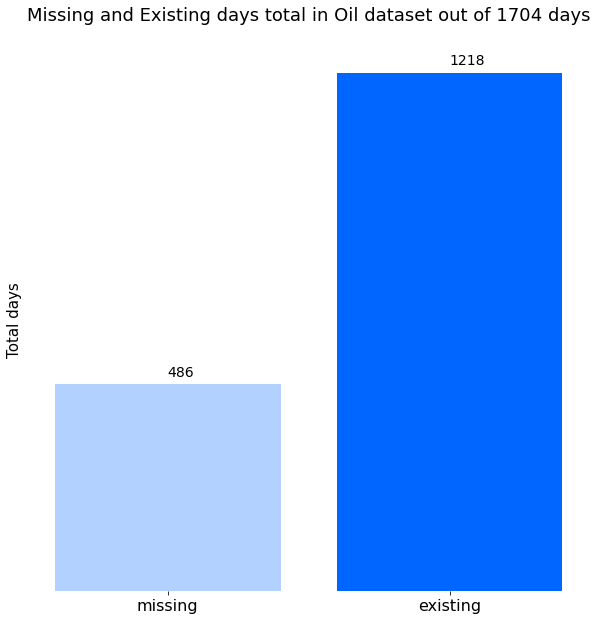

In [64]:
def plot_missing_dates(oil):
        
    dates = pd.DataFrame({"date":pd.date_range(start="2013-01-01", end="2017-08-31")})
    merged = dates.merge(oil, how="left", on="date")
    missing = dict(merged["dcoilwtico"].isna().value_counts())
    
    oil_days = {"missing": missing[True], "existing": missing[False]}
    plt.figure(figsize=(10,10))
    plt.bar(x=oil_days.keys(), height=oil_days.values(), color=["#b3d1ff","#0066ff"])
    
    plt.title("Missing and Existing days total in Oil dataset out of 1704 days\n", size=18)
    plt.xticks(size=16)
    plt.ylabel("Total days", size=15)
    
    plt.annotate(f"{missing[True]}", ("missing",oil_days["missing"]+20), size=14)
    plt.annotate(f"{missing[False]}", ("existing",oil_days["existing"]+20), size=14)
    
    plt.box(False)
    plt.yticks([])
    
plot_missing_dates(oil_prices.copy())

As we can see above, there are lot of missing oil data in oil prices data so we will not include this in for our prediction

## holidays dataset preparation

In [65]:
# Reading holidays dataset 
holidays = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
holidays["date"] = pd.to_datetime(holidays["date"])
holidays

date        type    locale locale_name  \
0   2012-03-02     Holiday     Local       Manta   
1   2012-04-01     Holiday  Regional    Cotopaxi   
2   2012-04-12     Holiday     Local      Cuenca   
3   2012-04-14     Holiday     Local    Libertad   
4   2012-04-21     Holiday     Local    Riobamba   
..         ...         ...       ...         ...   
345 2017-12-22  Additional  National     Ecuador   
346 2017-12-23  Additional  National     Ecuador   
347 2017-12-24  Additional  National     Ecuador   
348 2017-12-25     Holiday  National     Ecuador   
349 2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

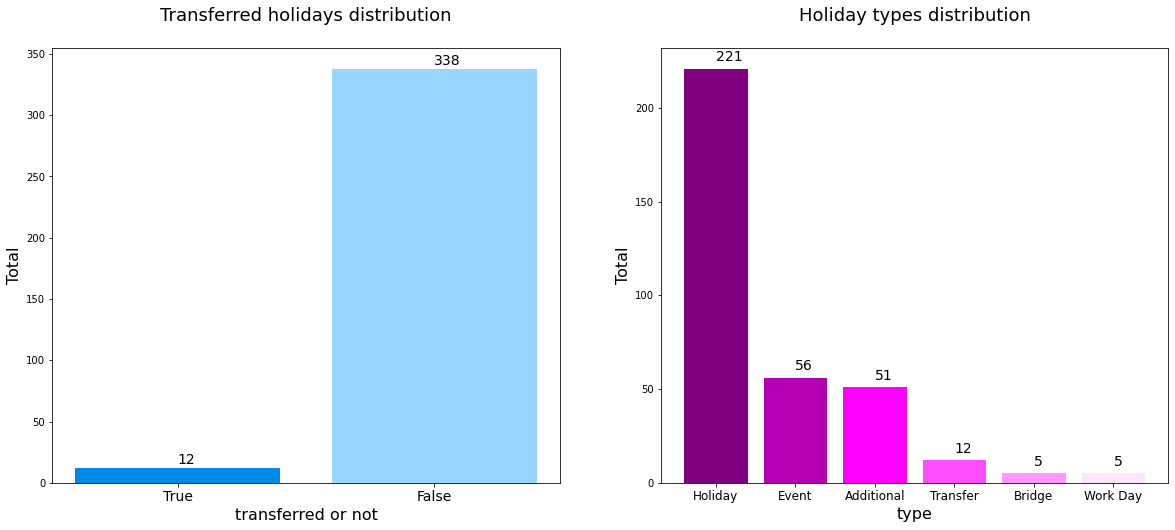

In [66]:
def plot_transferred_holidays(holidays):
    
    t = dict(holidays["transferred"].value_counts())
    transferred = {"True": t[True], "False": t[False]}
    
    holiday_type = dict(holidays["type"].value_counts())
    
    plt.figure(figsize=(20,8))
    left = plt.subplot(1,2,1)
    plt.bar(x = transferred.keys(), height = transferred.values(), color = ["#008ae6", "#99d6ff"])
    for key in transferred.keys():
        plt.annotate(f"{transferred[key]}", (key, transferred[key]+3), size=14)
    plt.xticks(size=14)
    left.set_title("Transferred holidays distribution\n", size=18)
    left.set_xlabel("transferred or not", size=16)
    left.set_ylabel("Total", size=16)
    
    
    right = plt.subplot(1,2,2)
    plt.bar(x = holiday_type.keys(), height = holiday_type.values(), color = ["#800080", "#b300b3", "#ff00ff", "#ff4dff", "#ff99ff", "#ffe6ff"])
    for key in holiday_type.keys():
        plt.annotate(f"{holiday_type[key]}", (key, holiday_type[key]+4), size=14)
    plt.xticks(size=12)
    right.set_title("Holiday types distribution\n", size=18)
    right.set_xlabel("type", size=16)
    right.set_ylabel("Total", size=16)

plot_transferred_holidays(holidays.copy())    

* Values in transferred column represent holidays which are transferred by the government, and it shows 12 are transferred (True) and 338 are not transferred (False).

* "type" column shows type of holiday and it also has "Transfer" type which contains 12 holidays.

* Thus, 12 True values in "transferred" column are transferred to some other days which are 12 "Transfer" values in "type" column.

* So we will drop 12 "True" values in "transferred" column and will change "Transfer" value in "type" column to "Holiday" since those are basically holidays.

In [67]:
# Dropping transferred holidays by government
transfer_true_idxs = holidays[holidays["transferred"] == True].index
holidays.drop(labels = transfer_true_idxs, axis=0, inplace=True)

# Dropping "Bridge" and "Work Day" type from holidays type because they are not on same date every year
type_BW = holidays[(holidays["type"] == "Bridge") | (holidays["type"] == "Work Day")].index
holidays.drop(labels = type_BW, axis=0, inplace=True)

holidays.reset_index(inplace=True)

# replacing "Transfer" type to "Holiday" because it is transferred holiday by government to "Transfer"(type) date
for i in range(len(holidays)):
    if holidays.loc[i,"type"] == "Transfer":
        holidays.loc[i,"type"] = "Holiday"
holidays["type"].value_counts()

Holiday       221
Event          56
Additional     51
Name: type, dtype: int64

Creating new column which will represent holiday "type" + "locale" together.

for e.g. if holiday type is "Holiday" and locale is "Regional" then value will be "HolidayRegional".

In [68]:
# Creating column consist of holiday "type" and "locale"
holidays["holiday_type"] = holidays.apply(lambda x: x["type"] + x["locale"], axis=1)

for i in range(len(holidays)):
    holidays.loc[i,"year"] = holidays.loc[i,"date"].year
    holidays.loc[i,"month"] = holidays.loc[i,"date"].month
    holidays.loc[i,"day"] = holidays.loc[i,"date"].day

holidays["monthday"] = holidays.apply(lambda x: x[-2]*100+x[-1], axis=1)
holidays

index       date        type    locale locale_name  \
0        0 2012-03-02     Holiday     Local       Manta   
1        1 2012-04-01     Holiday  Regional    Cotopaxi   
2        2 2012-04-12     Holiday     Local      Cuenca   
3        3 2012-04-14     Holiday     Local    Libertad   
4        4 2012-04-21     Holiday     Local    Riobamba   
..     ...        ...         ...       ...         ...   
323    345 2017-12-22  Additional  National     Ecuador   
324    346 2017-12-23  Additional  National     Ecuador   
325    347 2017-12-24  Additional  National     Ecuador   
326    348 2017-12-25     Holiday  National     Ecuador   
327    349 2017-12-26  Additional  National     Ecuador   

                       description  transferred        holiday_type    year  \
0               Fundacion de Manta        False        HolidayLocal  2012.0   
1    Provincializacion de Cotopaxi        False     HolidayRegional  2012.0   
2              Fundacion de Cuenca        False        HolidayLocal  2012.0   
3        Cantonizacion de Libertad        False        HolidayLocal  2012.0   
4        Cantonizacion de Riobamba        False        HolidayLocal  2012.0   
..                             ...          ...                 ...     ...   
323                      Navidad-3        False  AdditionalNational  2017.0   
324                      Navidad-2        False  AdditionalNational  2017.0   
325                      Navidad-1        False  AdditionalNational  2017.0   
326                        Navidad        False     HolidayNational  2017.0   
327                      Navidad+1        False  AdditionalNational  2017.0   

     month   day  monthday  
0      3.0   2.0     302.0  
1      4.0   1.0     401.0  
2      4.0  12.0     412.0  
3      4.0  14.0     414.0  
4      4.0  21.0     421.0  
..     ...   ...       ...  
323   12.0  22.0    1222.0  
324   12.0  23.0    1223.0  
325   12.0  24.0    1224.0  
326   12.0  25.0    1225.0  
327   12.0  26.0    1226.0  

[328 rows x 12 columns]

In [69]:
holidays[holidays["monthday"] == 625]

index       date     type    locale locale_name  \
7        7 2012-06-25  Holiday  Regional    Imbabura   
8        8 2012-06-25  Holiday     Local   Latacunga   
9        9 2012-06-25  Holiday     Local     Machala   
53      58 2013-06-25  Holiday  Regional    Imbabura   
54      59 2013-06-25  Holiday     Local     Machala   
55      60 2013-06-25  Holiday     Local   Latacunga   
104    110 2014-06-25  Holiday     Local   Latacunga   
105    111 2014-06-25  Holiday     Local     Machala   
106    112 2014-06-25  Holiday  Regional    Imbabura   
107    113 2014-06-25    Event  National     Ecuador   
165    176 2015-06-25  Holiday     Local     Machala   
166    177 2015-06-25  Holiday  Regional    Imbabura   
167    178 2015-06-25  Holiday     Local   Latacunga   
246    258 2016-06-25  Holiday     Local     Machala   
247    259 2016-06-25  Holiday  Regional    Imbabura   
248    260 2016-06-25  Holiday     Local   Latacunga   
296    315 2017-06-25  Holiday  Regional    Imbabura   
297    316 2017-06-25  Holiday     Local   Latacunga   
298    317 2017-06-25  Holiday     Local     Machala   

                                   description  transferred     holiday_type  \
7                Provincializacion de Imbabura        False  HolidayRegional   
8                   Cantonizacion de Latacunga        False     HolidayLocal   
9                         Fundacion de Machala        False     HolidayLocal   
53               Provincializacion de Imbabura        False  HolidayRegional   
54                        Fundacion de Machala        False     HolidayLocal   
55                  Cantonizacion de Latacunga        False     HolidayLocal   
104                 Cantonizacion de Latacunga        False     HolidayLocal   
105                       Fundacion de Machala        False     HolidayLocal   
106              Provincializacion de Imbabura        False  HolidayRegional   
107  Mundial de futbol Brasil: Ecuador-Francia        False    EventNational   
165                       Fundacion de Machala        False     HolidayLocal   
166              Provincializacion de Imbabura        False  HolidayRegional   
167                 Cantonizacion de Latacunga        False     HolidayLocal   
246                       Fundacion de Machala        False     HolidayLocal   
247              Provincializacion de Imbabura        False  HolidayRegional   
248                 Cantonizacion de Latacunga        False     HolidayLocal   
296              Provincializacion de Imbabura        False  HolidayRegional   
297                 Cantonizacion de Latacunga        False     HolidayLocal   
298                       Fundacion de Machala        False     HolidayLocal   

       year  month   day  monthday  
7    2012.0    6.0  25.0     625.0  
8    2012.0    6.0  25.0     625.0  
9    2012.0    6.0  25.0     625.0  
53   2013.0    6.0  25.0     625.0  
54   2013.0    6.0  25.0     625.0  
55   2013.0    6.0  25.0     625.0  
104  2014.0    6.0  25.0     625.0  
105  2014.0    6.0  25.0     625.0  
106  2014.0    6.0  25.0     625.0  
107  2014.0    6.0  25.0     625.0  
165  2015.0    6.0  25.0     625.0  
166  2015.0    6.0  25.0     625.0  
167  2015.0    6.0  25.0     625.0  
246  2016.0    6.0  25.0     625.0  
247  2016.0    6.0  25.0     625.0  
248  2016.0    6.0  25.0     625.0  
296  2017.0    6.0  25.0     625.0  
297  2017.0    6.0  25.0     625.0  
298  2017.0    6.0  25.0     625.0

* As we can see above some days have multiple holidays, we have to select most important/ highly preferenced among them.

* below will show high to low holiday preferences,

* HolidayNational > EventNational > AdditionalNational > HolidayRegional > HolidayLocal > AdditionalLocal

In [70]:
# we will encode "holidays_type" column with their precedence
holiday_type_dict = {'AdditionalLocal':1,
                     'HolidayLocal':2,
                     'HolidayRegional':3,
                     'AdditionalNational':4,
                     "EventNational":5,
                     'HolidayNational':6
                    }

holidays["holiday_type"] = holidays["holiday_type"].map(lambda x: holiday_type_dict[x])
holidays

index       date        type    locale locale_name  \
0        0 2012-03-02     Holiday     Local       Manta   
1        1 2012-04-01     Holiday  Regional    Cotopaxi   
2        2 2012-04-12     Holiday     Local      Cuenca   
3        3 2012-04-14     Holiday     Local    Libertad   
4        4 2012-04-21     Holiday     Local    Riobamba   
..     ...        ...         ...       ...         ...   
323    345 2017-12-22  Additional  National     Ecuador   
324    346 2017-12-23  Additional  National     Ecuador   
325    347 2017-12-24  Additional  National     Ecuador   
326    348 2017-12-25     Holiday  National     Ecuador   
327    349 2017-12-26  Additional  National     Ecuador   

                       description  transferred  holiday_type    year  month  \
0               Fundacion de Manta        False             2  2012.0    3.0   
1    Provincializacion de Cotopaxi        False             3  2012.0    4.0   
2              Fundacion de Cuenca        False             2  2012.0    4.0   
3        Cantonizacion de Libertad        False             2  2012.0    4.0   
4        Cantonizacion de Riobamba        False             2  2012.0    4.0   
..                             ...          ...           ...     ...    ...   
323                      Navidad-3        False             4  2017.0   12.0   
324                      Navidad-2        False             4  2017.0   12.0   
325                      Navidad-1        False             4  2017.0   12.0   
326                        Navidad        False             6  2017.0   12.0   
327                      Navidad+1        False             4  2017.0   12.0   

      day  monthday  
0     2.0     302.0  
1     1.0     401.0  
2    12.0     412.0  
3    14.0     414.0  
4    21.0     421.0  
..    ...       ...  
323  22.0    1222.0  
324  23.0    1223.0  
325  24.0    1224.0  
326  25.0    1225.0  
327  26.0    1226.0  

[328 rows x 12 columns]

In [71]:
# We will create "yearmonthday" column and will select high preferenced holiday from a day and drop the rest

holidays["yearmonthday"] = holidays.apply(lambda x: x[-4]*10000+x[-3]*100+x[-2], axis=1)

idxs_h = []
for md in holidays["yearmonthday"].unique():
    df = holidays[holidays["yearmonthday"] == md]
    idxs_h.append(df.sort_values(by="holiday_type", ascending=False).head(1).index[0])

Holidays = holidays.loc[idxs_h,:].copy()
Holidays

index       date        type    locale locale_name  \
0        0 2012-03-02     Holiday     Local       Manta   
1        1 2012-04-01     Holiday  Regional    Cotopaxi   
2        2 2012-04-12     Holiday     Local      Cuenca   
3        3 2012-04-14     Holiday     Local    Libertad   
4        4 2012-04-21     Holiday     Local    Riobamba   
..     ...        ...         ...       ...         ...   
323    345 2017-12-22  Additional  National     Ecuador   
324    346 2017-12-23  Additional  National     Ecuador   
325    347 2017-12-24  Additional  National     Ecuador   
326    348 2017-12-25     Holiday  National     Ecuador   
327    349 2017-12-26  Additional  National     Ecuador   

                       description  transferred  holiday_type    year  month  \
0               Fundacion de Manta        False             2  2012.0    3.0   
1    Provincializacion de Cotopaxi        False             3  2012.0    4.0   
2              Fundacion de Cuenca        False             2  2012.0    4.0   
3        Cantonizacion de Libertad        False             2  2012.0    4.0   
4        Cantonizacion de Riobamba        False             2  2012.0    4.0   
..                             ...          ...           ...     ...    ...   
323                      Navidad-3        False             4  2017.0   12.0   
324                      Navidad-2        False             4  2017.0   12.0   
325                      Navidad-1        False             4  2017.0   12.0   
326                        Navidad        False             6  2017.0   12.0   
327                      Navidad+1        False             4  2017.0   12.0   

      day  monthday  yearmonthday  
0     2.0     302.0    20120302.0  
1     1.0     401.0    20120401.0  
2    12.0     412.0    20120412.0  
3    14.0     414.0    20120414.0  
4    21.0     421.0    20120421.0  
..    ...       ...           ...  
323  22.0    1222.0    20171222.0  
324  23.0    1223.0    20171223.0  
325  24.0    1224.0    20171224.0  
326  25.0    1225.0    20171225.0  
327  26.0    1226.0    20171226.0  

[294 rows x 13 columns]

In [72]:
# Keeping "holiday_type" and "yearmonthday" (date) columns dropping the rest because "locale_name" and "description" column will not be useful

cleaned_holidays = Holidays.drop(columns = ["index","locale_name","date","type","locale","description","transferred","year"], axis=1).copy()

cleaned_holidays.reset_index(inplace=True)
cleaned_holidays.drop(columns=["index", "month", "day", "monthday"], axis=1, inplace=True)

cleaned_holidays

holiday_type  yearmonthday
0               2    20120302.0
1               3    20120401.0
2               2    20120412.0
3               2    20120414.0
4               2    20120421.0
..            ...           ...
289             4    20171222.0
290             4    20171223.0
291             4    20171224.0
292             6    20171225.0
293             4    20171226.0

[294 rows x 2 columns]

## stores dataset preparation

In [73]:
# Reading stores data
stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

Creating "city_state" column which will represent "city" + "state" 

In [74]:
# Creating "city_state" column 
stores["city_state"] = stores.apply(lambda x: x[1] + x[2], axis=1)
stores.head()

store_nbr           city                           state type  cluster  \
0          1          Quito                       Pichincha    D       13   
1          2          Quito                       Pichincha    D       13   
2          3          Quito                       Pichincha    D        8   
3          4          Quito                       Pichincha    D        9   
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4   

                                    city_state  
0                               QuitoPichincha  
1                               QuitoPichincha  
2                               QuitoPichincha  
3                               QuitoPichincha  
4  Santo DomingoSanto Domingo de los Tsachilas

Since we are going to use tree based algorithms we will encode "city_sate" and "type" which are categorical data in Numbers using Numerical Encoding which is simply assigning numbers to the categories.

In [75]:
# Encoding "city_state" and "type" (store) using numerical encoding
city_state_enc = {}
num = 1
for cs in stores["city_state"].unique():
    city_state_enc[cs] = num
    num += 1

stores["city_state"] = stores["city_state"].map(lambda x: city_state_enc[x])


store_type_enc = {}
for typ in stores["type"].value_counts().index:
    store_type_enc[typ] = stores["type"].value_counts()[typ]

stores["type"] = stores["type"].map(lambda x: store_type_enc[x])
stores.head()

store_nbr           city                           state  type  cluster  \
0          1          Quito                       Pichincha    18       13   
1          2          Quito                       Pichincha    18       13   
2          3          Quito                       Pichincha    18        8   
3          4          Quito                       Pichincha    18        9   
4          5  Santo Domingo  Santo Domingo de los Tsachilas    18        4   

   city_state  
0           1  
1           1  
2           1  
3           1  
4           2

In [76]:
stores.drop(columns = ["city", "state"], axis=1, inplace=True)
stores.head()

store_nbr  type  cluster  city_state
0          1    18       13           1
1          2    18       13           1
2          3    18        8           1
3          4    18        9           1
4          5    18        4           2

## training dataset (sales) preparation

In [77]:
# Reading sales training data 
data = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
data["date"] = pd.to_datetime(data["date"])
data.drop(["id"], axis=1, inplace=True)
data

date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 5 columns]

In [78]:
data["year"] = data["date"].map(lambda x: x.year)
data["month"] = data["date"].map(lambda x: x.month)
data["day"] = data["date"].map(lambda x: x.day)
data["yearmonthday"] = data.apply(lambda x: x[-3]*10000+x[-2]*100+x[-1], axis=1)
data

date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  year  month  day  yearmonthday  
0                  0  2013      1    1      20130101  
1                  0  2013      1    1      20130101  
2                  0  2013      1    1      20130101  
3                  0  2013      1    1      20130101  
4                  0  2013      1    1      20130101  
...              ...   ...    ...  ...           ...  
3000883            0  2017      8   15      20170815  
3000884            1  2017      8   15      20170815  
3000885          148  2017      8   15      20170815  
3000886            8  2017      8   15      20170815  
3000887            0  2017      8   15      20170815  

[3000888 rows x 9 columns]

Merging holidays dataset and stores dataset in our training sales data.

In [79]:
# merging holidays dataset in sales data
merged_data= data.merge(cleaned_holidays, how="left", on="yearmonthday").copy()

# merging stores dataset in sales data
merged_data = merged_data.merge(stores, how="left", on="store_nbr").copy()
merged_data

date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  year  month  day  yearmonthday  holiday_type  type  \
0                  0  2013      1    1      20130101           6.0    18   
1                  0  2013      1    1      20130101           6.0    18   
2                  0  2013      1    1      20130101           6.0    18   
3                  0  2013      1    1      20130101           6.0    18   
4                  0  2013      1    1      20130101           6.0    18   
...              ...   ...    ...  ...           ...           ...   ...   
3000883            0  2017      8   15      20170815           2.0     8   
3000884            1  2017      8   15      20170815           2.0     8   
3000885          148  2017      8   15      20170815           2.0     8   
3000886            8  2017      8   15      20170815           2.0     8   
3000887            0  2017      8   15      20170815           2.0     8   

         cluster  city_state  
0             13           1  
1             13           1  
2             13           1  
3             13           1  
4             13           1  
...          ...         ...  
3000883        6           1  
3000884        6           1  
3000885        6           1  
3000886        6           1  
3000887        6           1  

[3000888 rows x 13 columns]

In [80]:
# there are null values in holiday_type column
merged_data["holiday_type"].isna().value_counts()

True     2578554
False     422334
Name: holiday_type, dtype: int64

In [81]:
# we will replace those with 0 since those are normal days
merged_data["holiday_type"].fillna(0, inplace=True)
merged_data["holiday_type"].isna().value_counts()

False    3000888
Name: holiday_type, dtype: int64

In [82]:
# Encoding store "family" with numerical encoding beacuse we will be using tree based algorithms we will not encode in one hot encoding
family_dict = {}
i = 1
for family in merged_data["family"].unique():
    family_dict[family] = i
    i += 1

merged_data["family"] = merged_data["family"].map(lambda x: family_dict[x])
merged_data

date  store_nbr  family     sales  onpromotion  year  month  \
0       2013-01-01          1       1     0.000            0  2013      1   
1       2013-01-01          1       2     0.000            0  2013      1   
2       2013-01-01          1       3     0.000            0  2013      1   
3       2013-01-01          1       4     0.000            0  2013      1   
4       2013-01-01          1       5     0.000            0  2013      1   
...            ...        ...     ...       ...          ...   ...    ...   
3000883 2017-08-15          9      29   438.133            0  2017      8   
3000884 2017-08-15          9      30   154.553            1  2017      8   
3000885 2017-08-15          9      31  2419.729          148  2017      8   
3000886 2017-08-15          9      32   121.000            8  2017      8   
3000887 2017-08-15          9      33    16.000            0  2017      8   

         day  yearmonthday  holiday_type  type  cluster  city_state  
0          1      20130101           6.0    18       13           1  
1          1      20130101           6.0    18       13           1  
2          1      20130101           6.0    18       13           1  
3          1      20130101           6.0    18       13           1  
4          1      20130101           6.0    18       13           1  
...      ...           ...           ...   ...      ...         ...  
3000883   15      20170815           2.0     8        6           1  
3000884   15      20170815           2.0     8        6           1  
3000885   15      20170815           2.0     8        6           1  
3000886   15      20170815           2.0     8        6           1  
3000887   15      20170815           2.0     8        6           1  

[3000888 rows x 13 columns]

Since "day" and "month" are recurring / cyclic features we will create new features with sine transformation applied on them.

Sine Transformation is used when feature is cyclic in nature.

In [83]:
# creating month and day columns with sine transformation because months and dates are recurring
merged_data["month_sin"] = merged_data["date"].map(lambda x: np.sin((x.month-1)*(2*np.pi)/12))
merged_data["day_sin"] = merged_data["date"].map(lambda x: np.sin(x.day*(2*np.pi)/31))
merged_data

date  store_nbr  family     sales  onpromotion  year  month  \
0       2013-01-01          1       1     0.000            0  2013      1   
1       2013-01-01          1       2     0.000            0  2013      1   
2       2013-01-01          1       3     0.000            0  2013      1   
3       2013-01-01          1       4     0.000            0  2013      1   
4       2013-01-01          1       5     0.000            0  2013      1   
...            ...        ...     ...       ...          ...   ...    ...   
3000883 2017-08-15          9      29   438.133            0  2017      8   
3000884 2017-08-15          9      30   154.553            1  2017      8   
3000885 2017-08-15          9      31  2419.729          148  2017      8   
3000886 2017-08-15          9      32   121.000            8  2017      8   
3000887 2017-08-15          9      33    16.000            0  2017      8   

         day  yearmonthday  holiday_type  type  cluster  city_state  \
0          1      20130101           6.0    18       13           1   
1          1      20130101           6.0    18       13           1   
2          1      20130101           6.0    18       13           1   
3          1      20130101           6.0    18       13           1   
4          1      20130101           6.0    18       13           1   
...      ...           ...           ...   ...      ...         ...   
3000883   15      20170815           2.0     8        6           1   
3000884   15      20170815           2.0     8        6           1   
3000885   15      20170815           2.0     8        6           1   
3000886   15      20170815           2.0     8        6           1   
3000887   15      20170815           2.0     8        6           1   

         month_sin   day_sin  
0              0.0  0.201299  
1              0.0  0.201299  
2              0.0  0.201299  
3              0.0  0.201299  
4              0.0  0.201299  
...            ...       ...  
3000883       -0.5  0.101168  
3000884       -0.5  0.101168  
3000885       -0.5  0.101168  
3000886       -0.5  0.101168  
3000887       -0.5  0.101168  

[3000888 rows x 15 columns]

We are creating 2 new features for additional information 

1. "payday" : This features represents day of the payment which are generally on 15th day and 30th/31st day of the month.

2. "day_of_week" : This will represent day number of week , monday will be 1 tuesday will be 2 and so on.

In [84]:
merged_data["monthday"] = merged_data.apply(lambda x: x[6]*100+x[7], axis=1)

# creating "payday" column which represents paydays of the month
def get_payday(x):
    if x in [115, 131, 215, 228, 229, 315, 331, 415, 430, 515, 531, 615, 630, 715, 731, 815, 831, 915, 930, 1015, 1031, 1115, 1130, 1215, 1231]:
        return 1
    else:
        return 0
merged_data["payday"] = merged_data["monthday"].map(lambda x: get_payday(x))


# creating "day_of_week" column for more information on weekdays and weekends
day_no = 2
for date in pd.date_range(start="2013-01-01", end="2017-08-15"):
    if day_no <=7:
        idxss = merged_data[merged_data["date"] == date].index
        merged_data.loc[idxss,"day_of_week"] = day_no
        day_no += 1
    else:
        day_no = 1
        idxss = merged_data[merged_data["date"] == date].index
        merged_data.loc[idxss,"day_of_week"] = day_no
        day_no += 1
        
merged_data

date  store_nbr  family     sales  onpromotion  year  month  \
0       2013-01-01          1       1     0.000            0  2013      1   
1       2013-01-01          1       2     0.000            0  2013      1   
2       2013-01-01          1       3     0.000            0  2013      1   
3       2013-01-01          1       4     0.000            0  2013      1   
4       2013-01-01          1       5     0.000            0  2013      1   
...            ...        ...     ...       ...          ...   ...    ...   
3000883 2017-08-15          9      29   438.133            0  2017      8   
3000884 2017-08-15          9      30   154.553            1  2017      8   
3000885 2017-08-15          9      31  2419.729          148  2017      8   
3000886 2017-08-15          9      32   121.000            8  2017      8   
3000887 2017-08-15          9      33    16.000            0  2017      8   

         day  yearmonthday  holiday_type  type  cluster  city_state  \
0          1      20130101           6.0    18       13           1   
1          1      20130101           6.0    18       13           1   
2          1      20130101           6.0    18       13           1   
3          1      20130101           6.0    18       13           1   
4          1      20130101           6.0    18       13           1   
...      ...           ...           ...   ...      ...         ...   
3000883   15      20170815           2.0     8        6           1   
3000884   15      20170815           2.0     8        6           1   
3000885   15      20170815           2.0     8        6           1   
3000886   15      20170815           2.0     8        6           1   
3000887   15      20170815           2.0     8        6           1   

         month_sin   day_sin  monthday  payday  day_of_week  
0              0.0  0.201299       101       0          2.0  
1              0.0  0.201299       101       0          2.0  
2              0.0  0.201299       101       0          2.0  
3              0.0  0.201299       101       0          2.0  
4              0.0  0.201299       101       0          2.0  
...            ...       ...       ...     ...          ...  
3000883       -0.5  0.101168       815       1          2.0  
3000884       -0.5  0.101168       815       1          2.0  
3000885       -0.5  0.101168       815       1          2.0  
3000886       -0.5  0.101168       815       1          2.0  
3000887       -0.5  0.101168       815       1          2.0  

[3000888 rows x 18 columns]

In [85]:
Final_data = merged_data.copy()
Final_data.describe()

store_nbr        family         sales   onpromotion          year  \
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06   
mean   2.750000e+01  1.700000e+01  3.577757e+02  2.602770e+00  2.014838e+03   
std    1.558579e+01  9.521906e+00  1.101998e+03  1.221888e+01  1.345518e+00   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  2.013000e+03   
25%    1.400000e+01  9.000000e+00  0.000000e+00  0.000000e+00  2.014000e+03   
50%    2.750000e+01  1.700000e+01  1.100000e+01  0.000000e+00  2.015000e+03   
75%    4.100000e+01  2.500000e+01  1.958473e+02  0.000000e+00  2.016000e+03   
max    5.400000e+01  3.300000e+01  1.247170e+05  7.410000e+02  2.017000e+03   

              month           day  yearmonthday  holiday_type          type  \
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06   
mean   6.207838e+00  1.563005e+01  2.014902e+07  5.279097e-01  1.314815e+01   
std    3.385668e+00  8.794789e+00  1.341074e+04  1.444477e+00  4.668284e+00   
min    1.000000e+00  1.000000e+00  2.013010e+07  0.000000e+00  4.000000e+00   
25%    3.000000e+00  8.000000e+00  2.014023e+07  0.000000e+00  9.000000e+00   
50%    6.000000e+00  1.600000e+01  2.015042e+07  0.000000e+00  1.500000e+01   
75%    9.000000e+00  2.300000e+01  2.016062e+07  0.000000e+00  1.800000e+01   
max    1.200000e+01  3.100000e+01  2.017082e+07  6.000000e+00  1.800000e+01   

            cluster    city_state     month_sin       day_sin      monthday  \
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06   
mean   8.481481e+00  7.981481e+00  6.093930e-02  9.616440e-03  6.364139e+02   
std    4.649735e+00  6.881244e+00  6.968484e-01  7.128580e-01  3.387040e+02   
min    1.000000e+00  1.000000e+00 -1.000000e+00 -9.987165e-01  1.010000e+02   
25%    4.000000e+00  1.000000e+00 -5.000000e-01 -7.247928e-01  3.257500e+02   
50%    8.500000e+00  7.500000e+00  1.224647e-16 -2.449294e-16  6.180000e+02   
75%    1.300000e+01  1.300000e+01  8.660254e-01  7.247928e-01  9.160000e+02   
max    1.700000e+01  2.200000e+01  1.000000e+00  9.987165e-01  1.231000e+03   

             payday   day_of_week  
count  3.000888e+06  3.000888e+06  
mean   6.650831e-02  3.997031e+00  
std    2.491686e-01  2.000740e+00  
min    0.000000e+00  1.000000e+00  
25%    0.000000e+00  2.000000e+00  
50%    0.000000e+00  4.000000e+00  
75%    0.000000e+00  6.000000e+00  
max    1.000000e+00  7.000000e+00

# Model Building

In [86]:
# splitting data into training and evaluation sets
training = Final_data[Final_data["date"] <= "2017-07-15"].copy()
testing = Final_data[Final_data["date"] >= "2017-07-15"].copy()
x_train, y_train = training.loc[:,["store_nbr","family","onpromotion","year","month_sin","day_sin","payday","holiday_type","type","cluster","city_state","day_of_week"]], training["sales"]
x_test, y_test = testing.loc[:,["store_nbr","family","onpromotion","year","month_sin","day_sin","payday","holiday_type","type","cluster","city_state","day_of_week"]], testing["sales"]

**Using Xgboost Regressor for Predicting Sales**

In [87]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

xgbR = XGBRegressor(n_estimators=200, eta=0.2)
xgbR.fit(x_train, y_train)

y_pred_xgbR = xgbR.predict(x_test)

print(f"Xgboost Regressor Score\n\n r squared: {r2_score(y_test, y_pred_xgbR)}\n\n RMSE: {mean_squared_error(y_test, y_pred_xgbR, squared=False)}")

Xgboost Regressor Score

 r squared: 0.9463684307652872

 RMSE: 298.35145564295937


**The model with Xgboost Regressor is 94.63% accuarate.**

**We will plot the predicted sales with actual sales for checking models accuracy.**

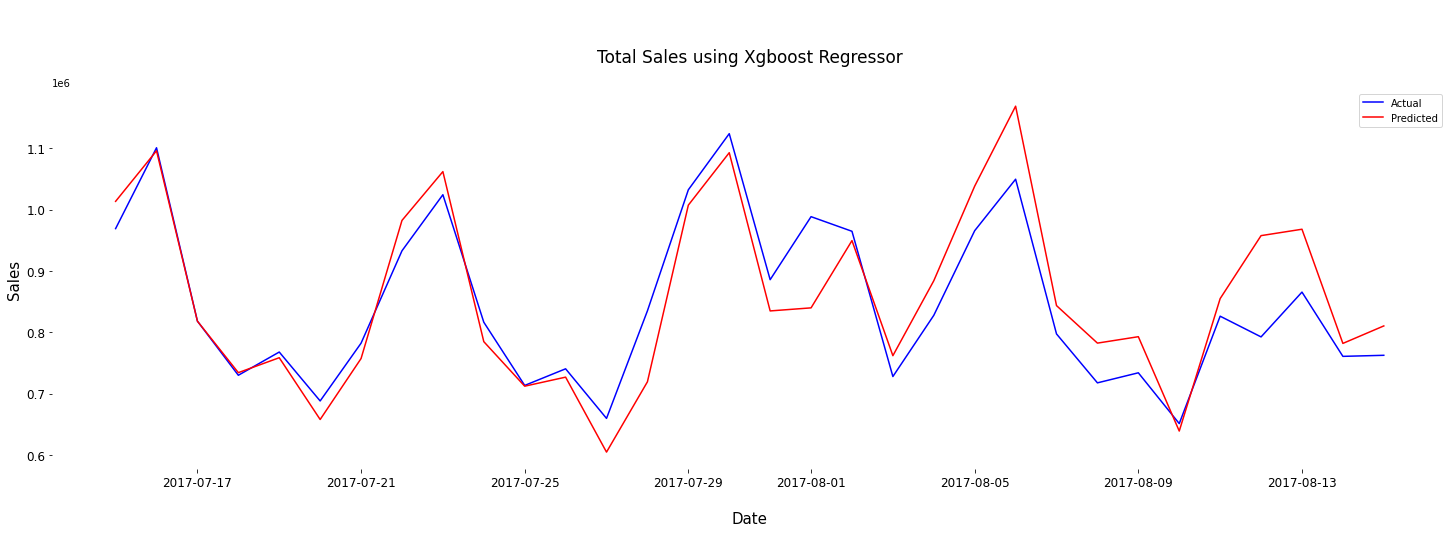

In [88]:
def plot_sales_total_predicted(testing):
    testing_with_pred = testing.copy()
    testing_with_pred["sales_pred"] = y_pred_xgbR
    
    testing_with_pred = testing_with_pred.groupby("date").sum()

    plt.figure(figsize=(25,7))
    act = plt.plot(testing_with_pred.index, testing_with_pred["sales"], color="blue")
    pred = plt.plot(testing_with_pred.index, testing_with_pred["sales_pred"], color="red")
    
    plt.xlabel("\nDate", size=15)
    plt.ylabel("Sales", size=15)
    
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    plt.title(f"\n\nTotal Sales using Xgboost Regressor\n", size=17)
    plt.legend(["Actual","Predicted"])
    plt.box(False)

plot_sales_total_predicted(testing.copy())   

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


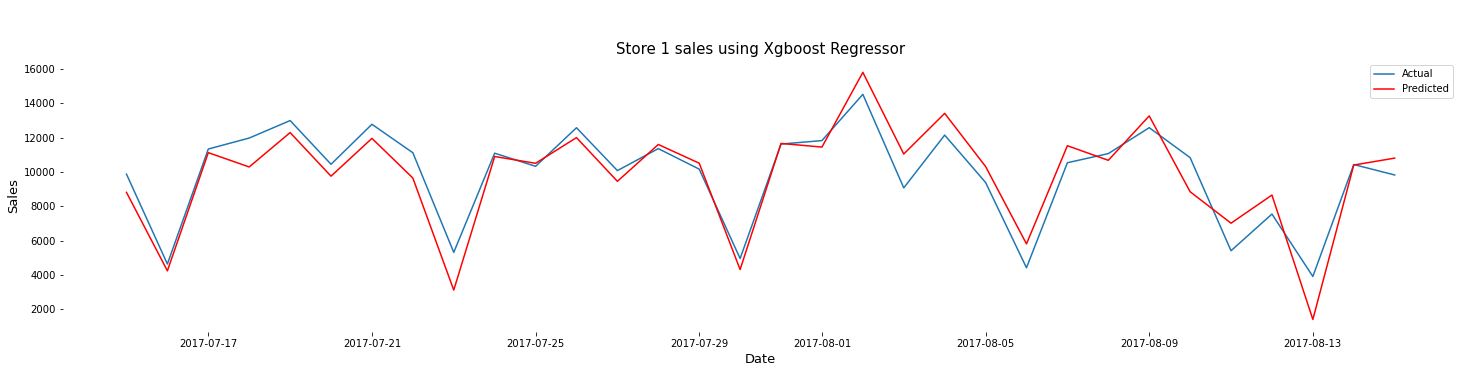

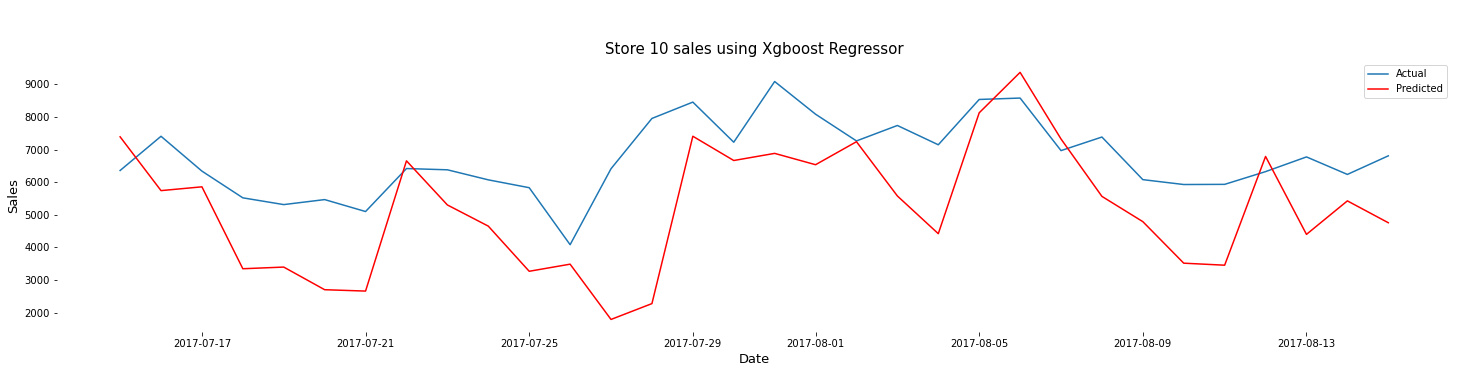

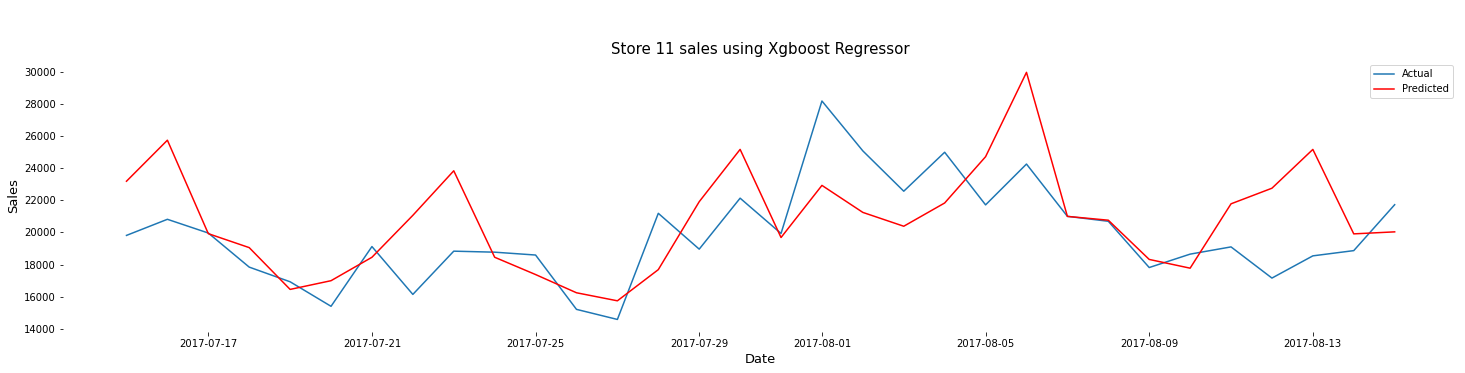

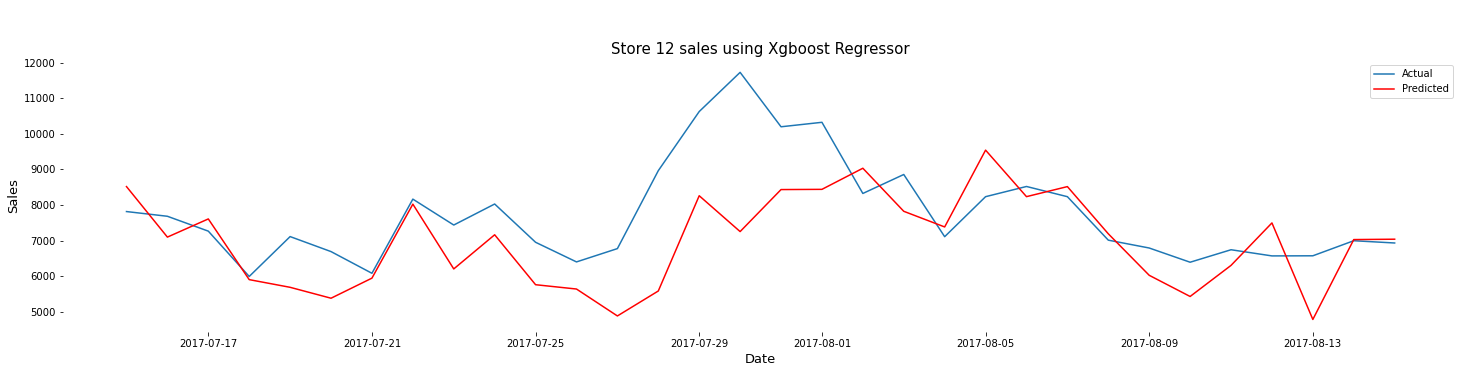

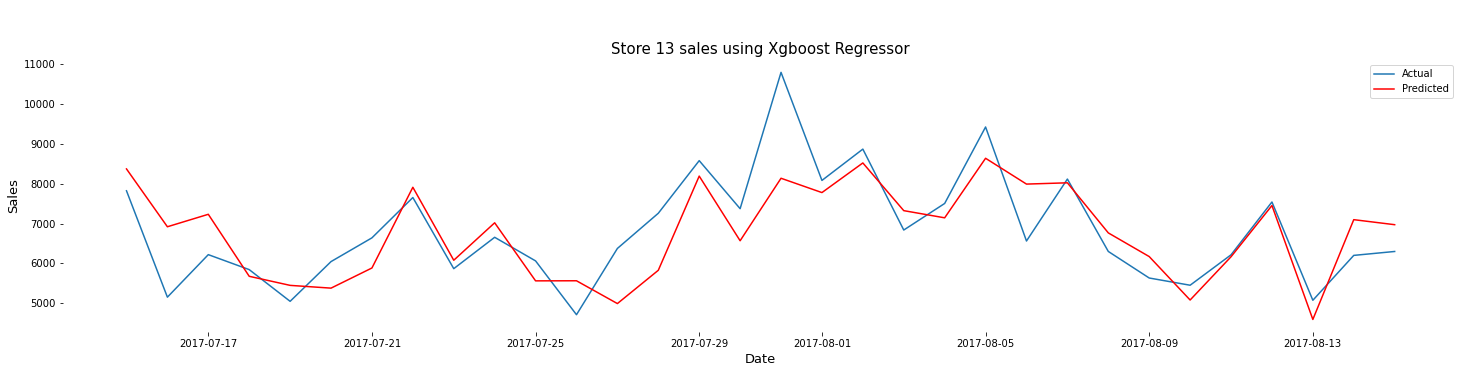

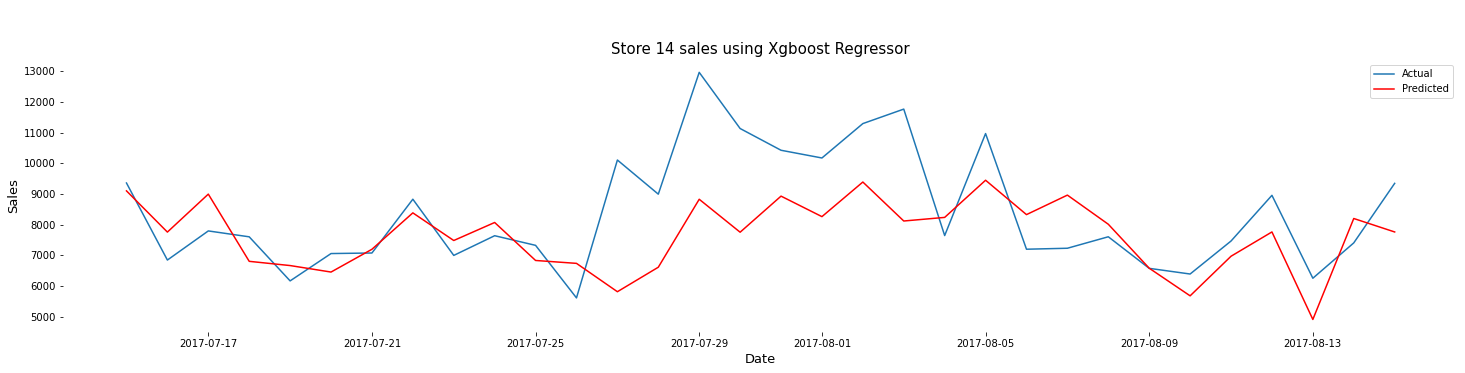

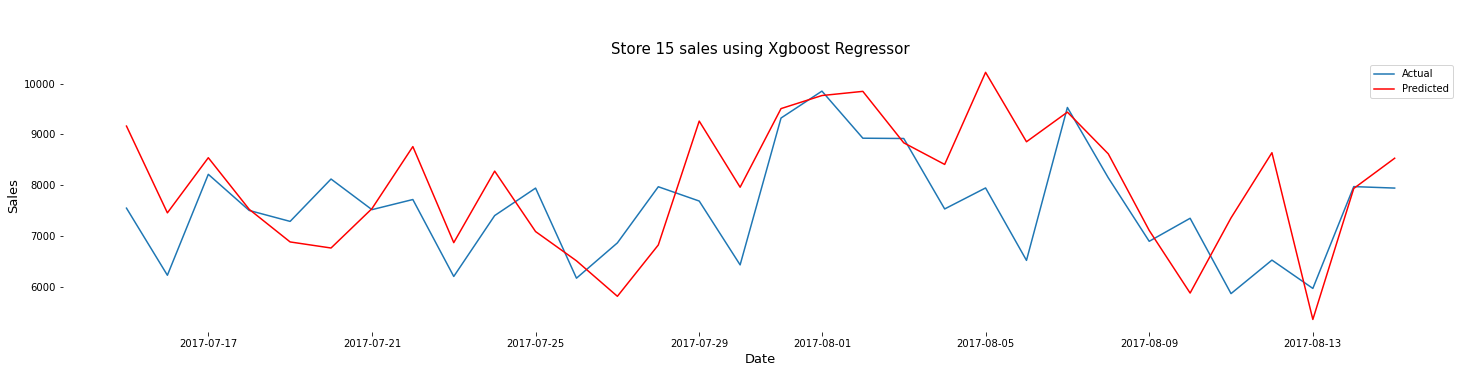

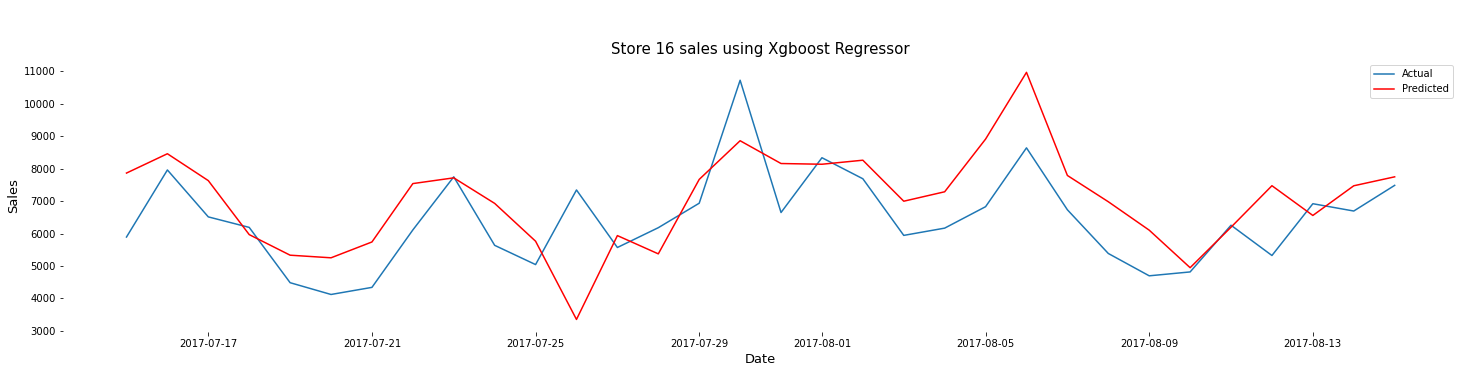

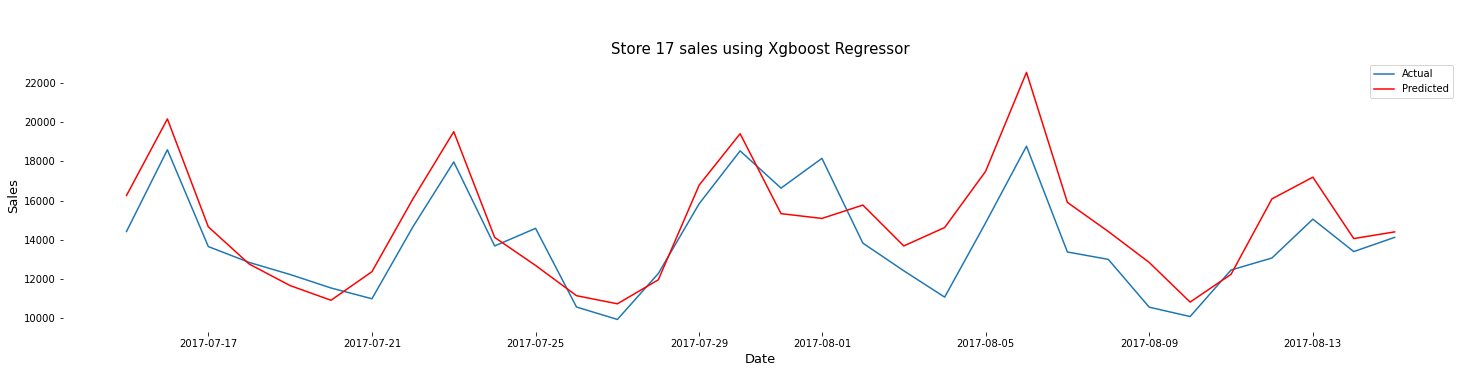

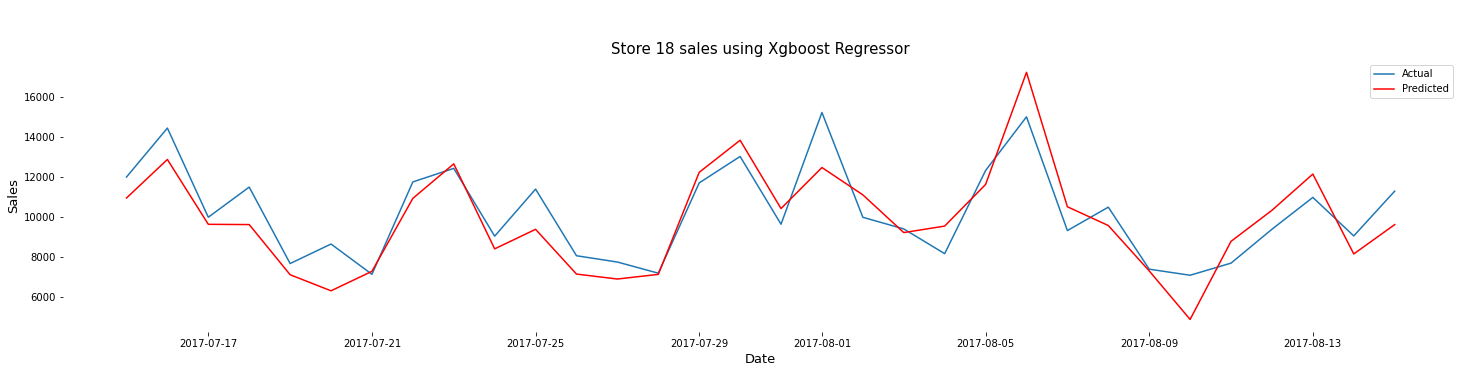

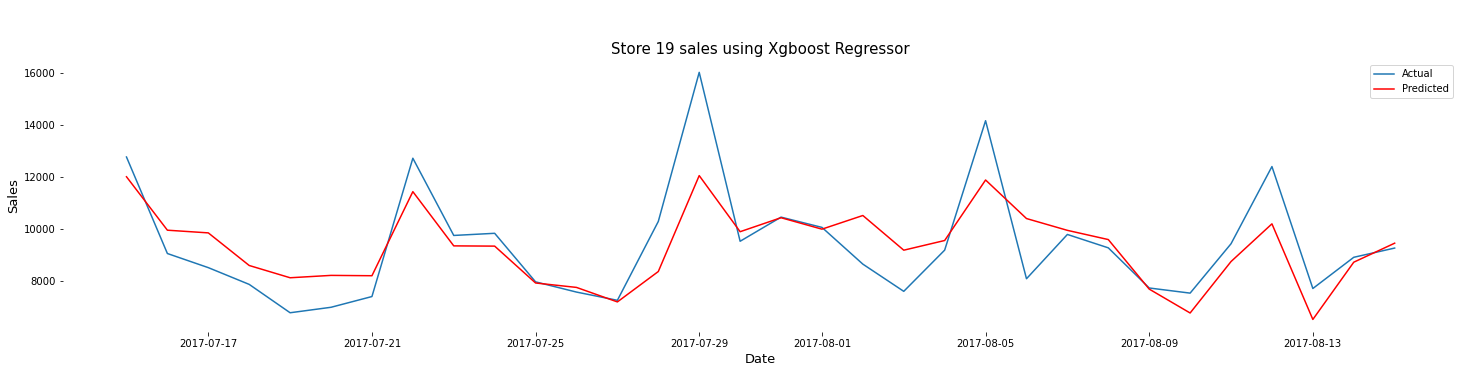

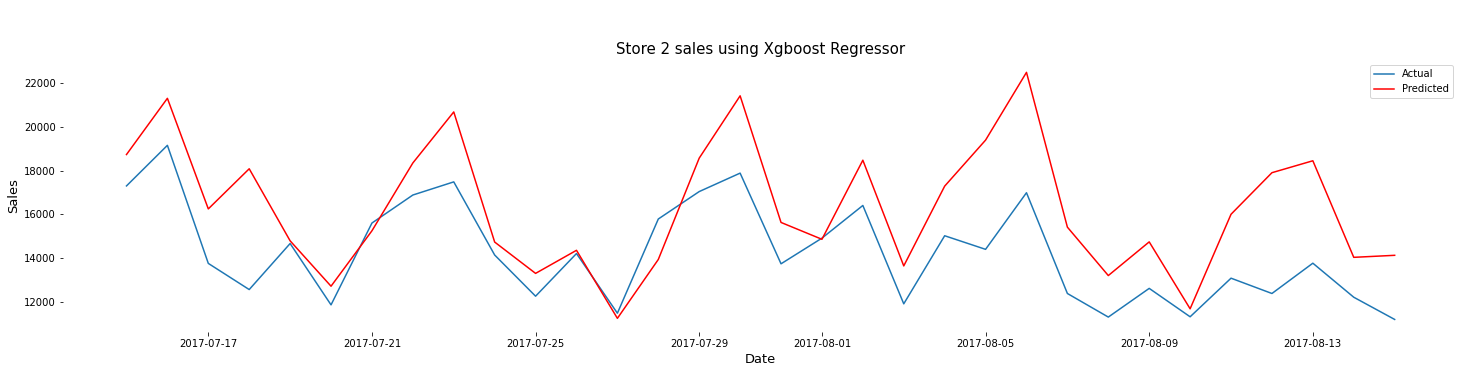

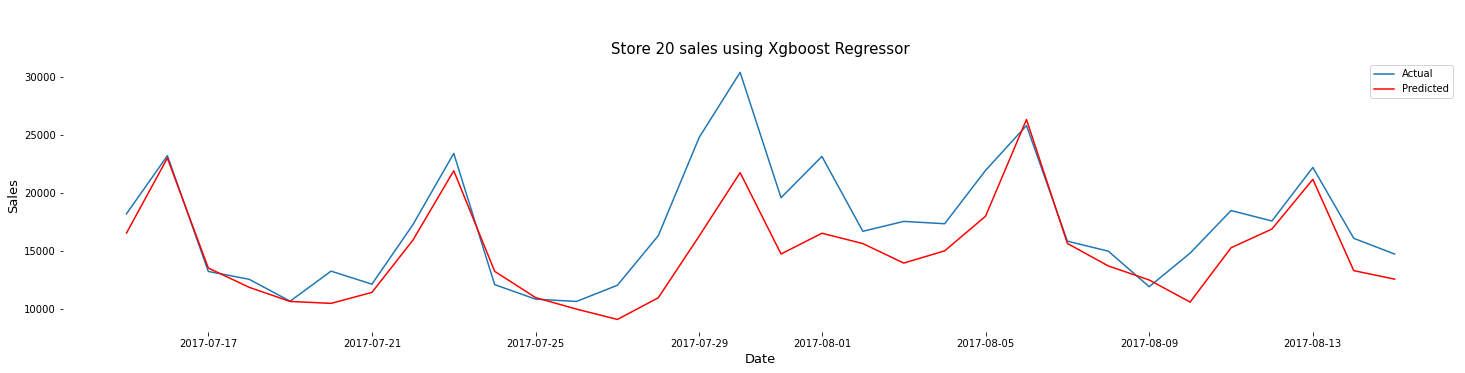

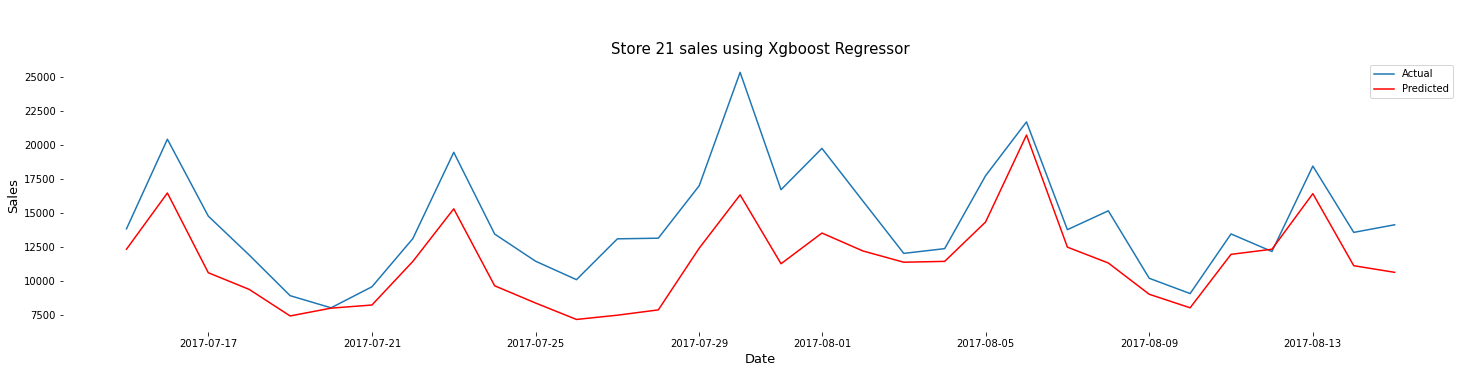

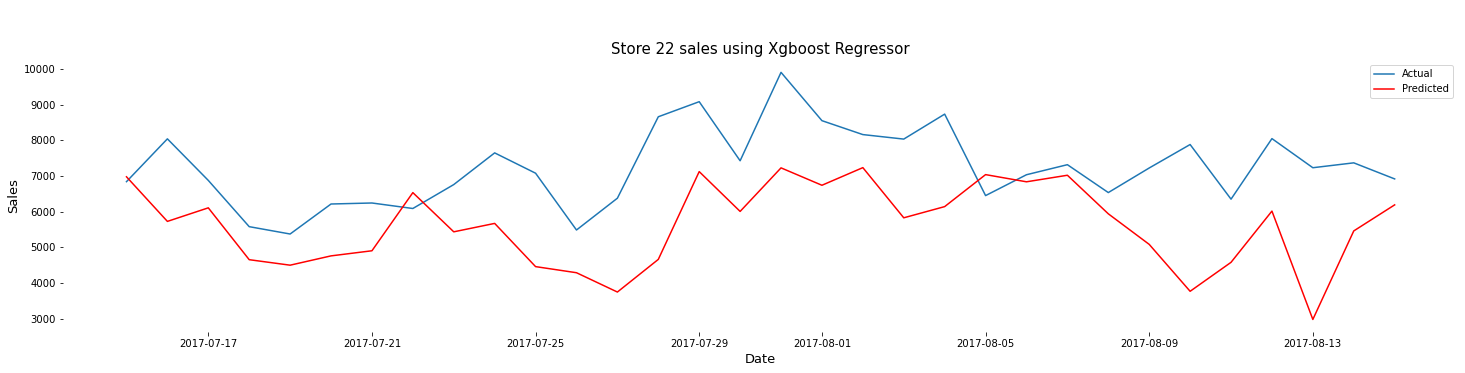

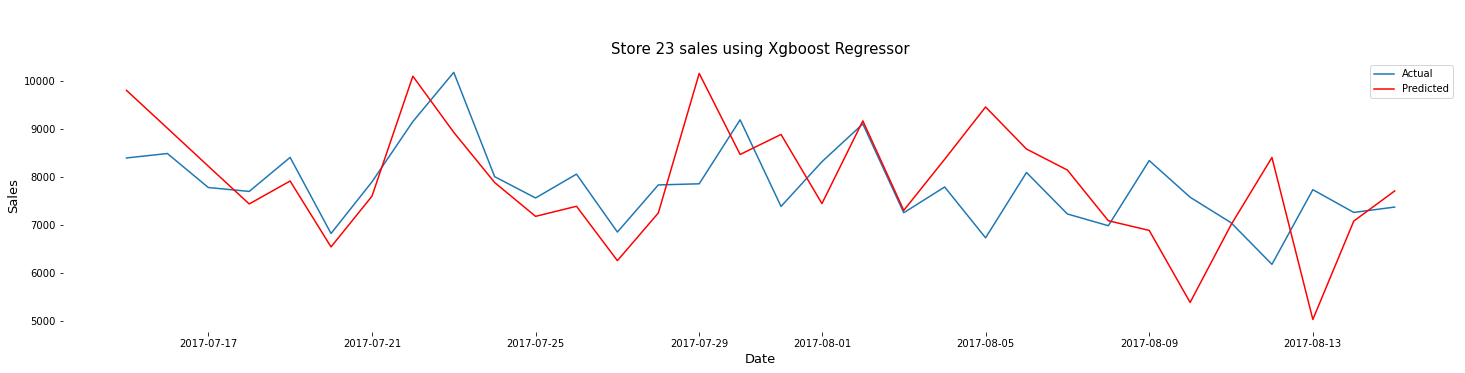

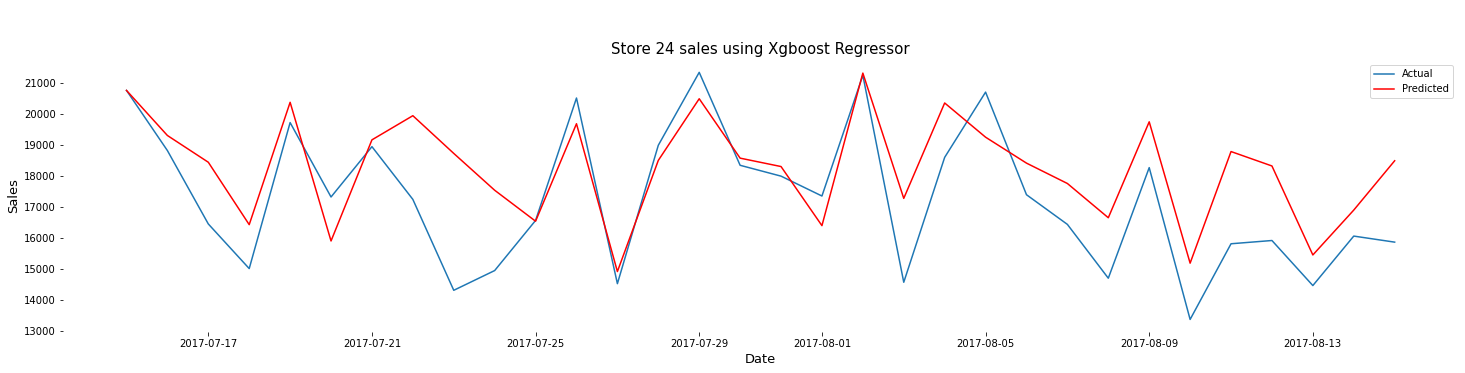

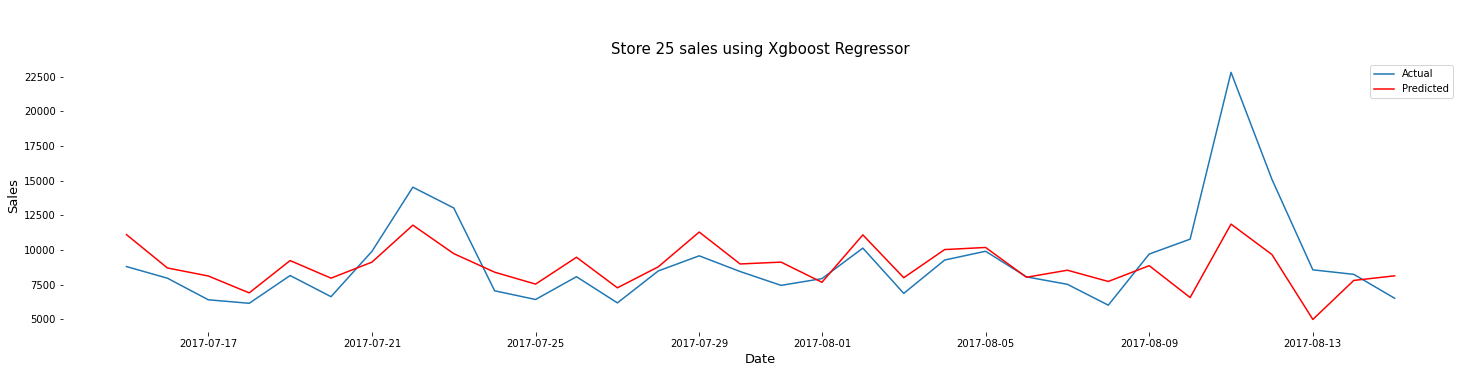

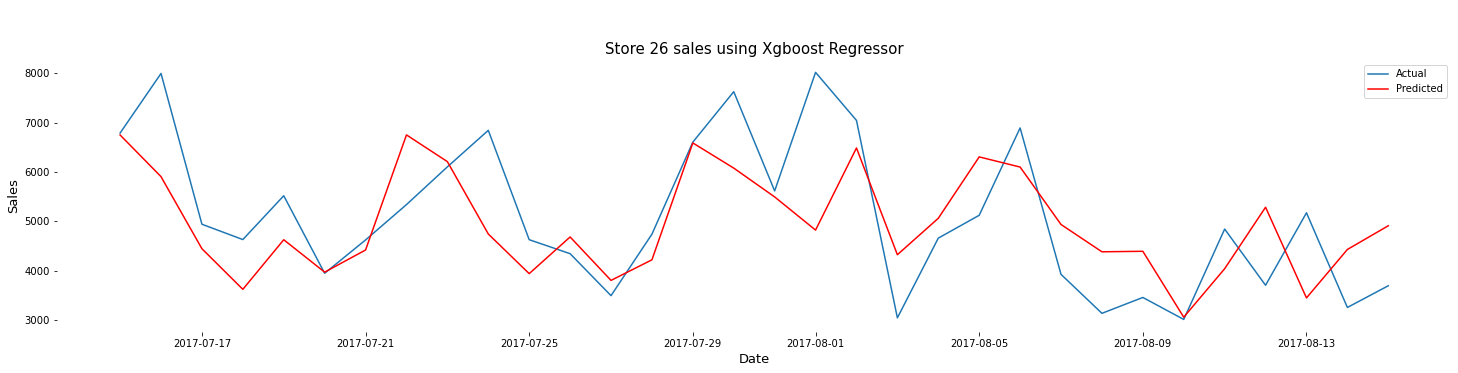

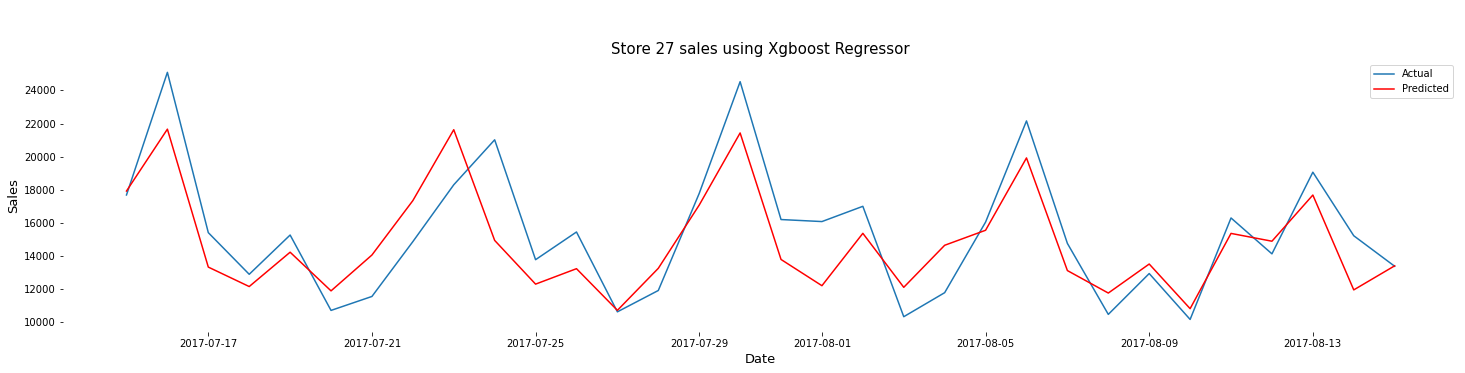

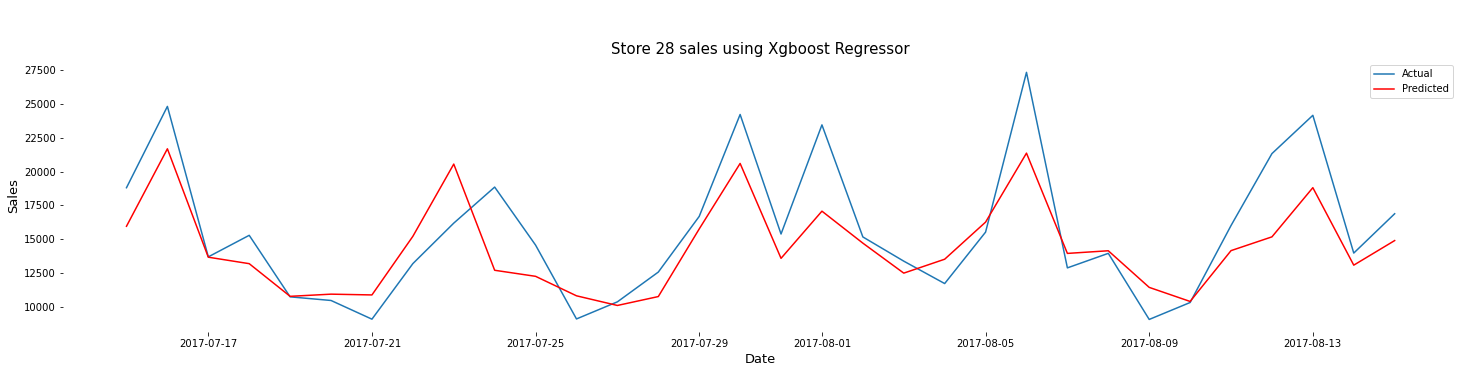

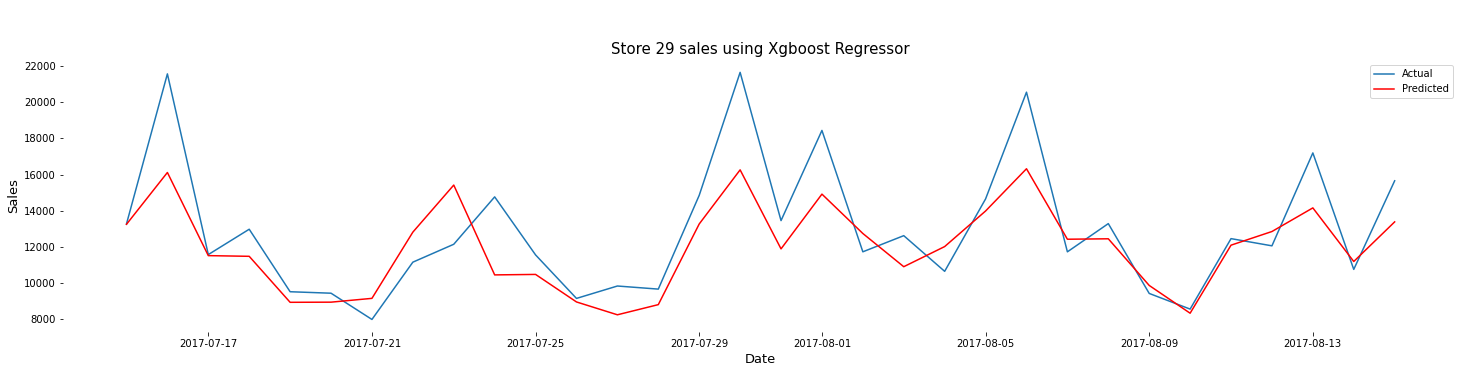

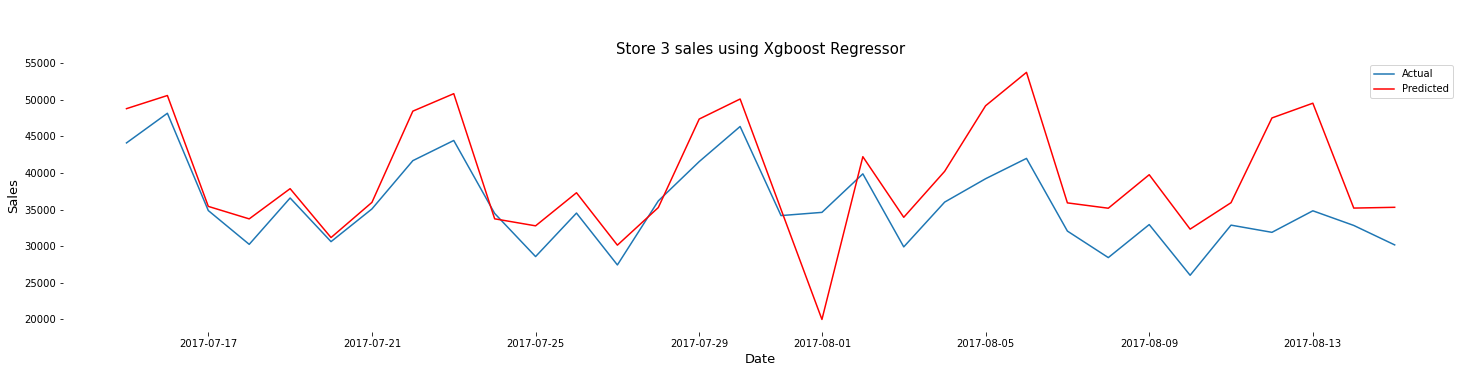

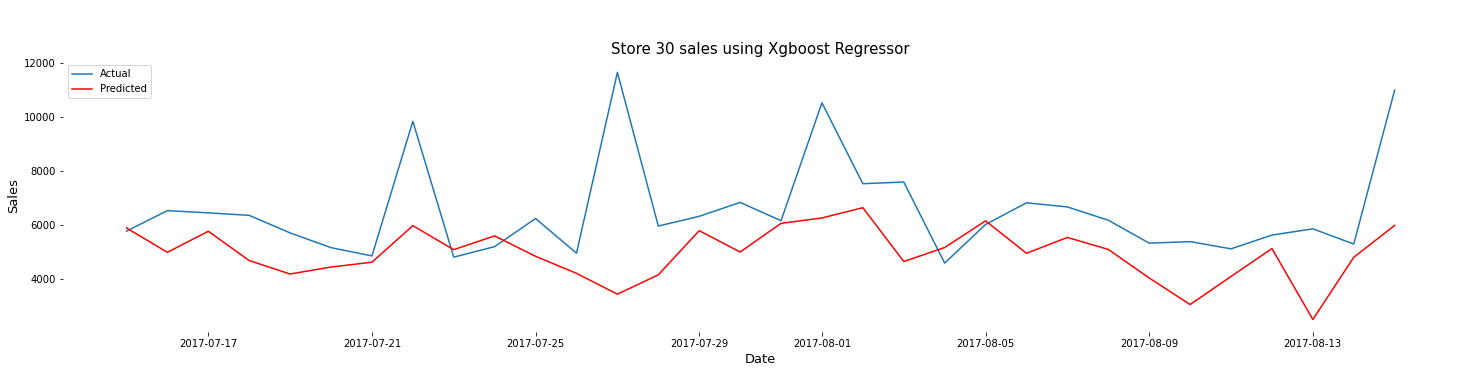

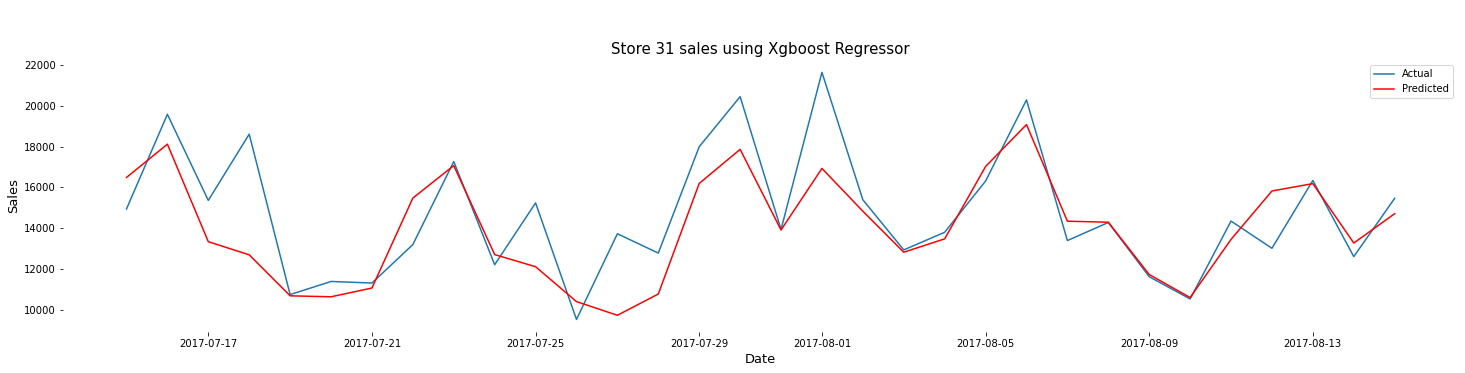

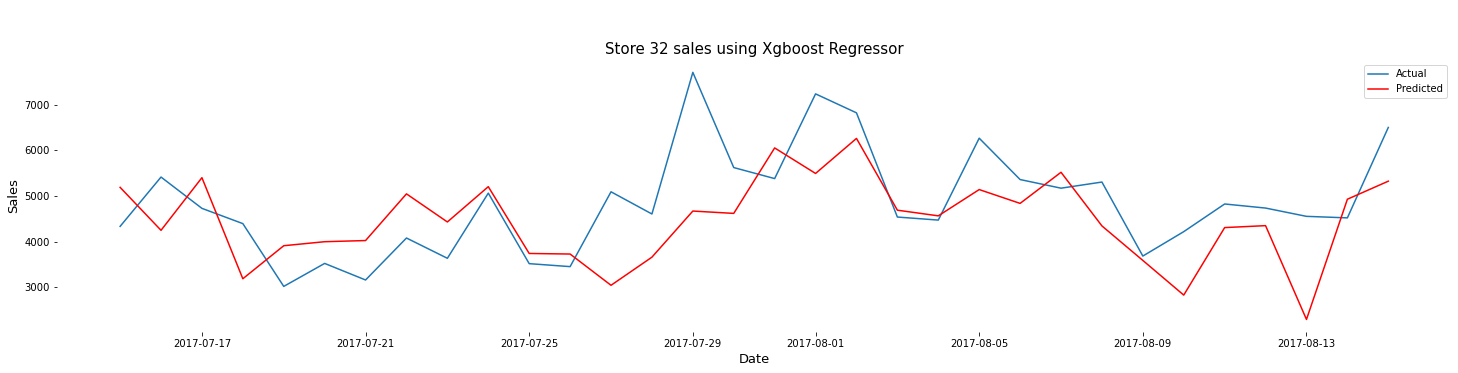

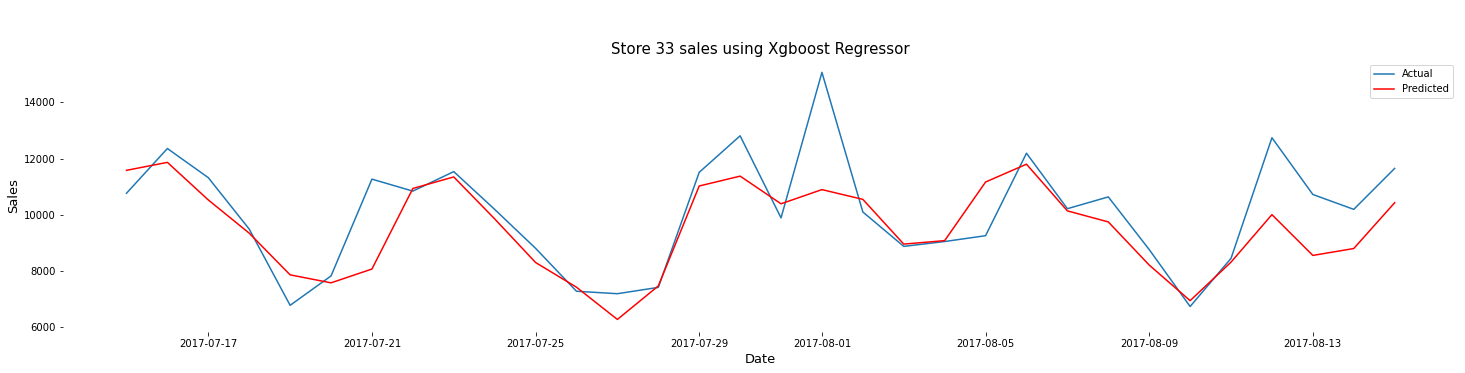

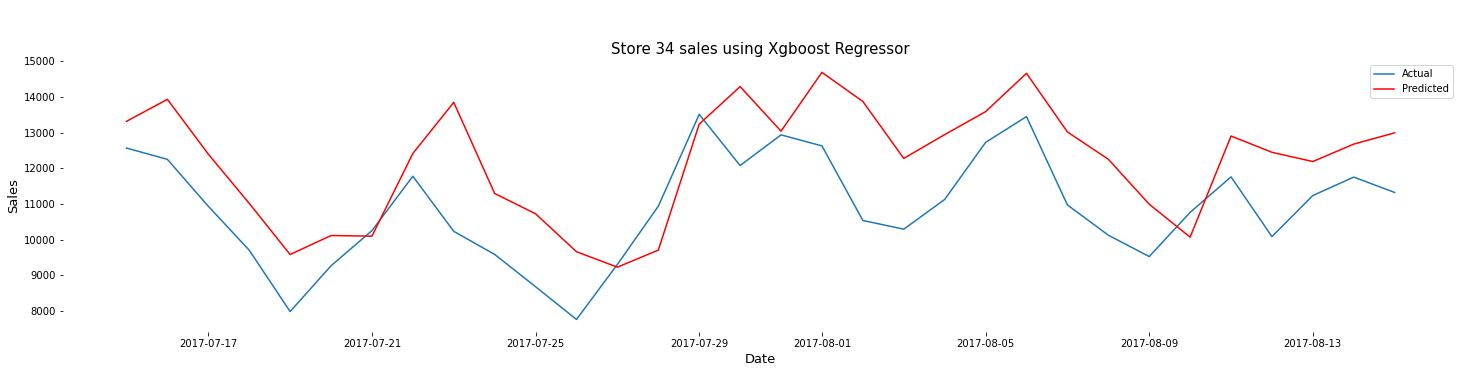

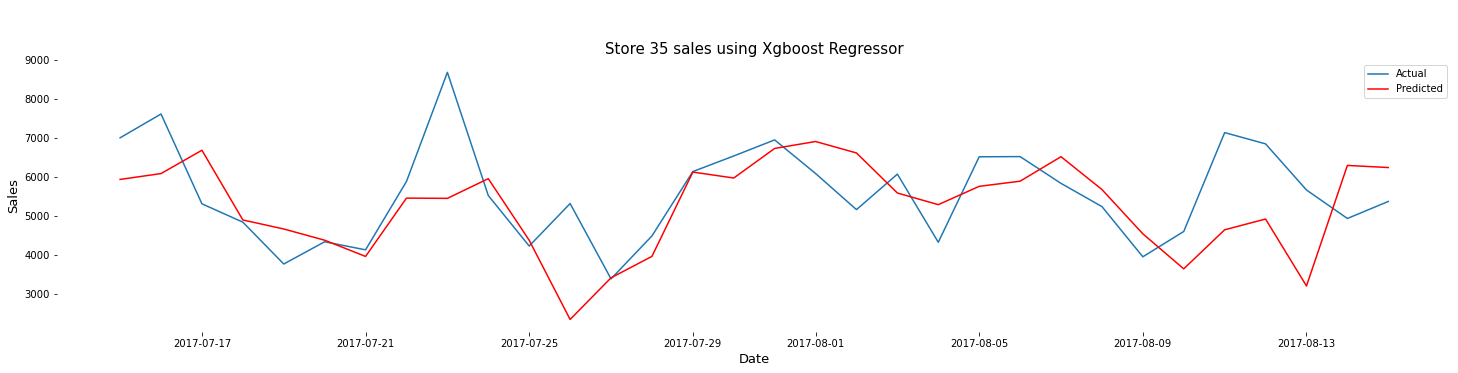

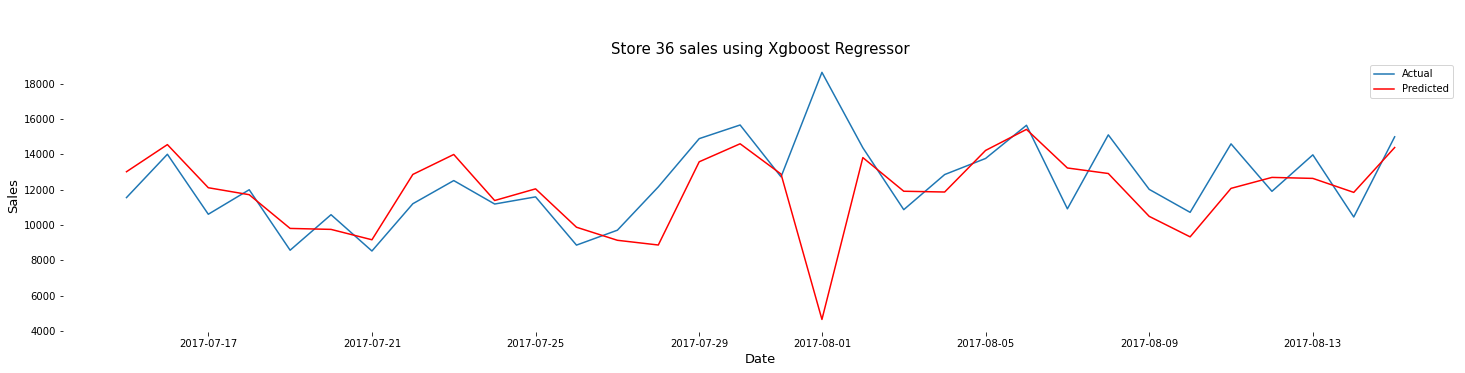

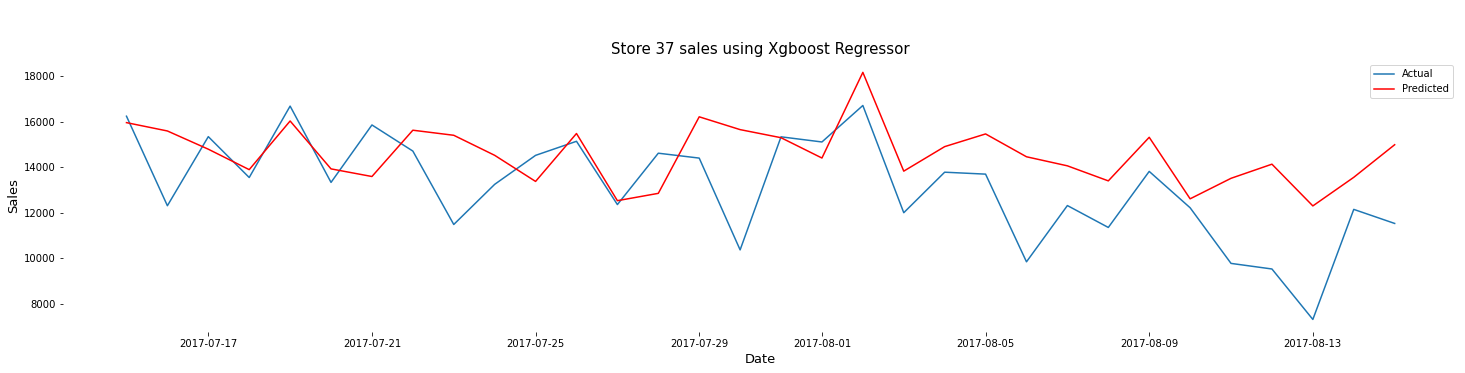

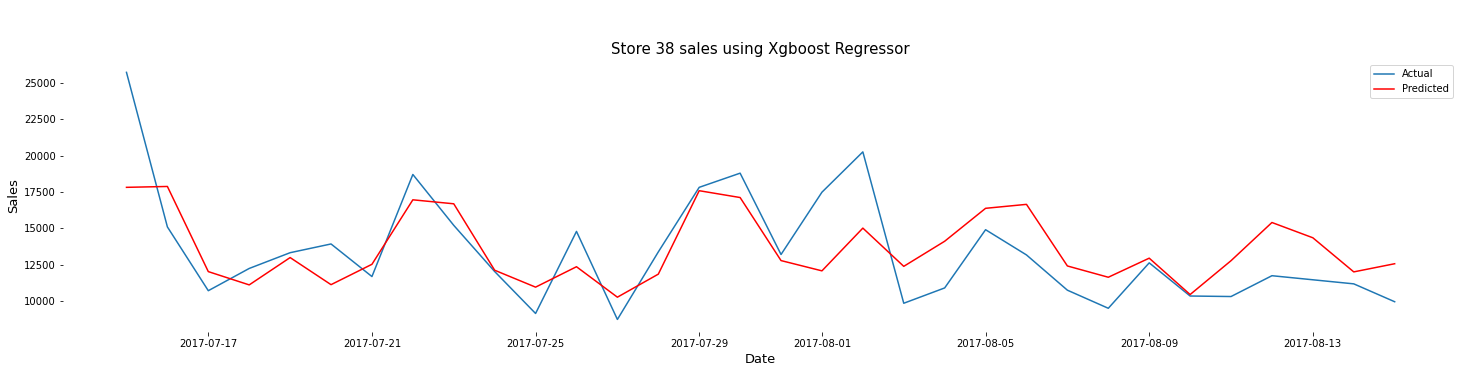

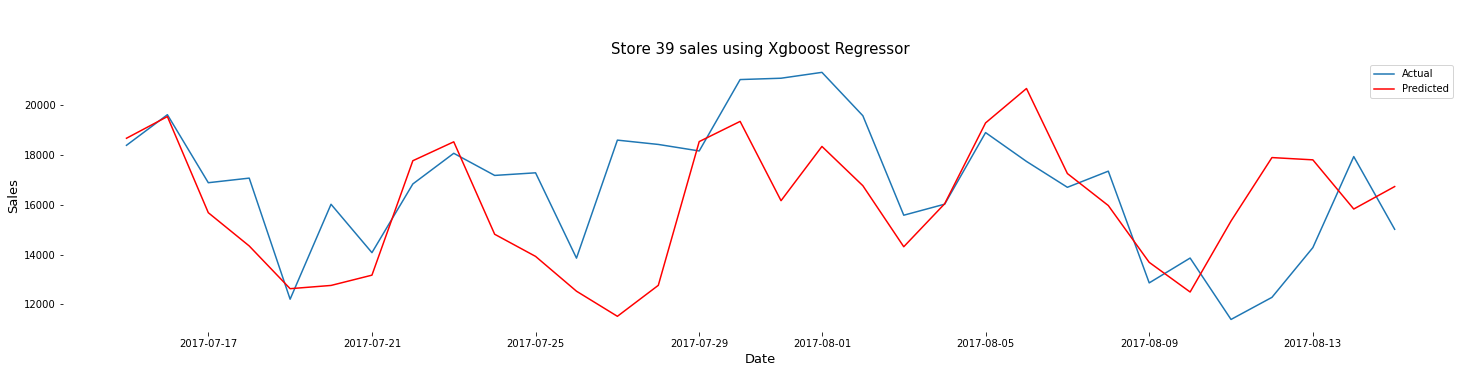

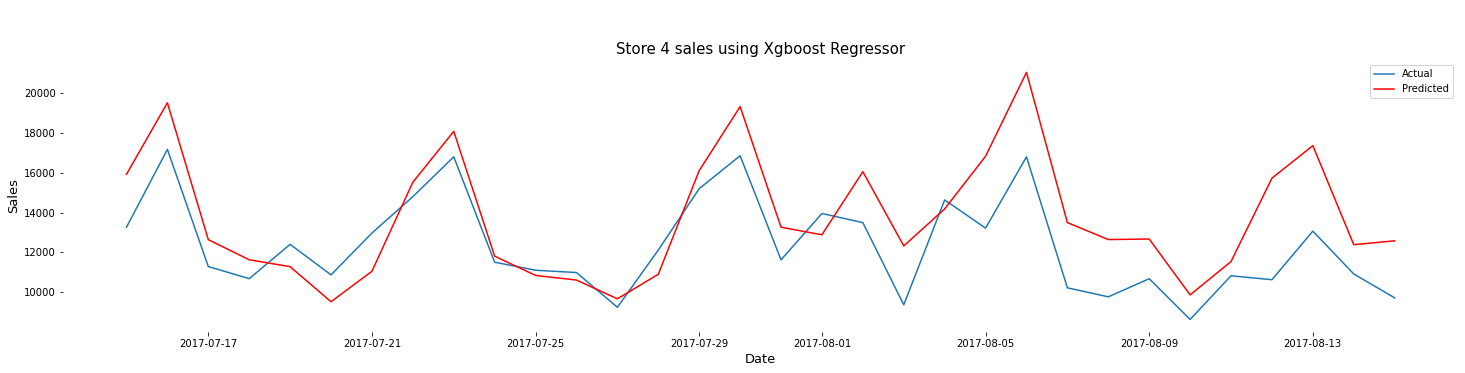

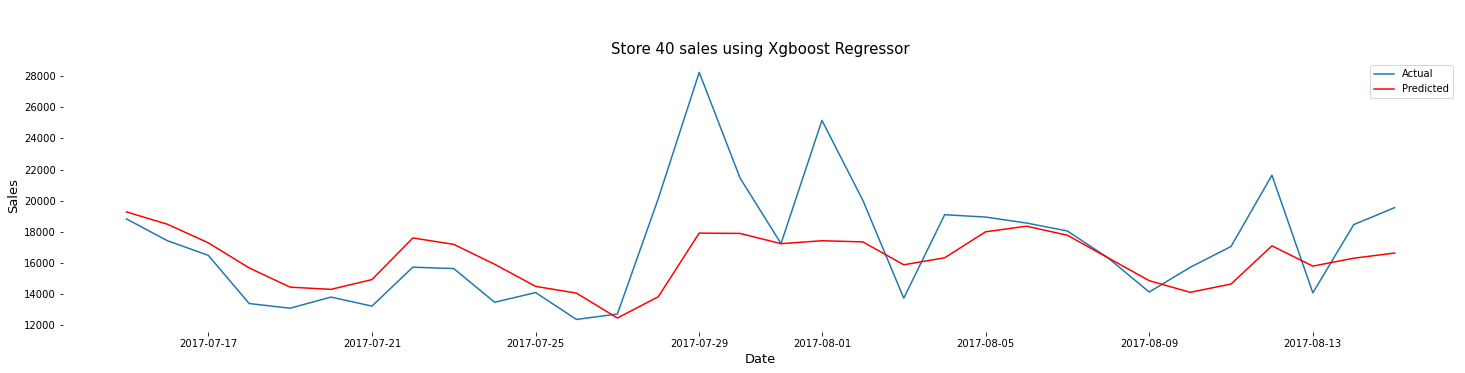

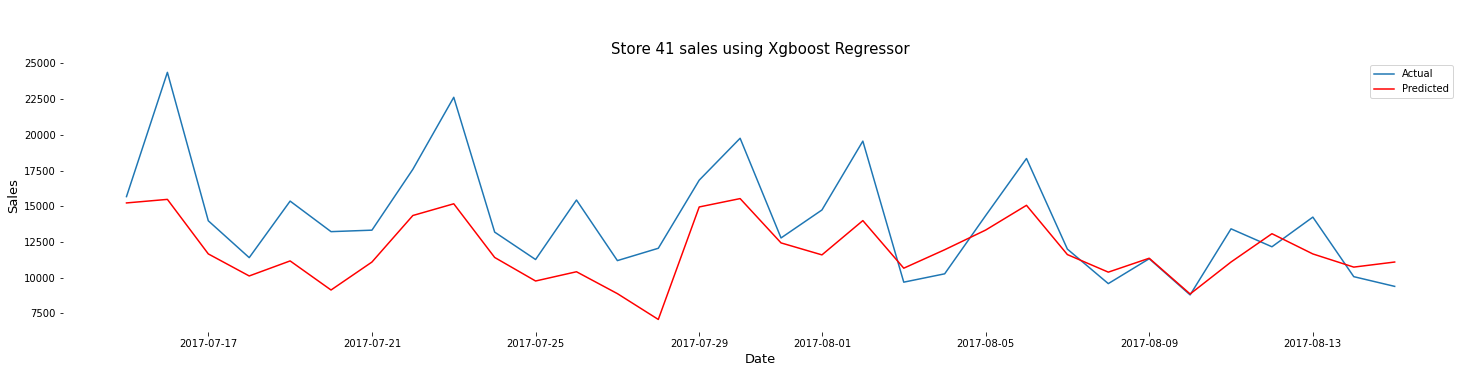

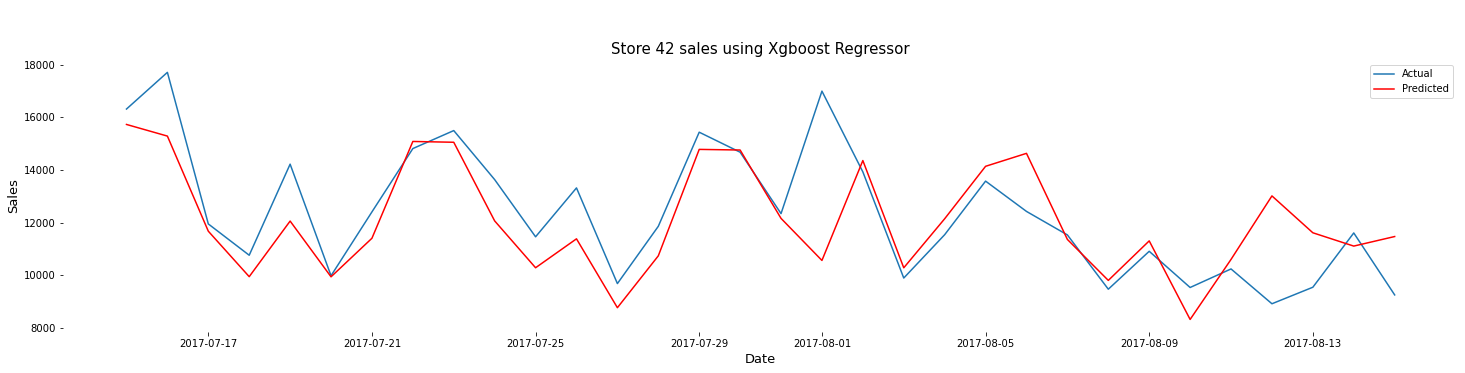

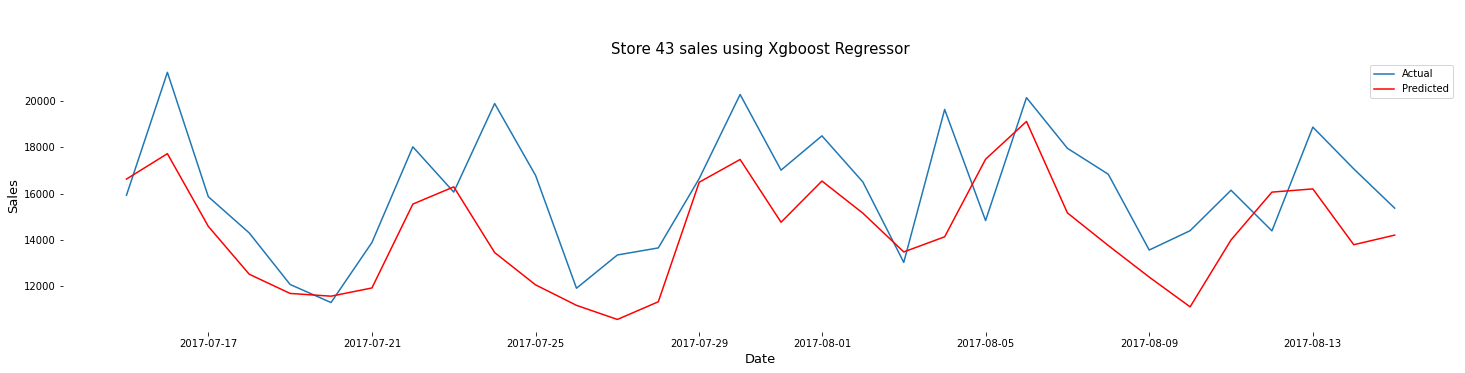

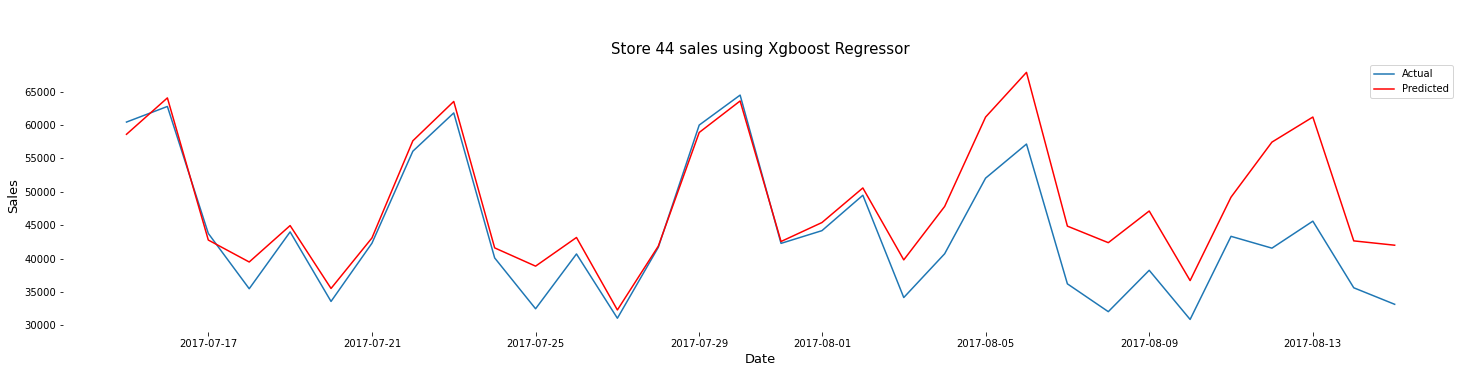

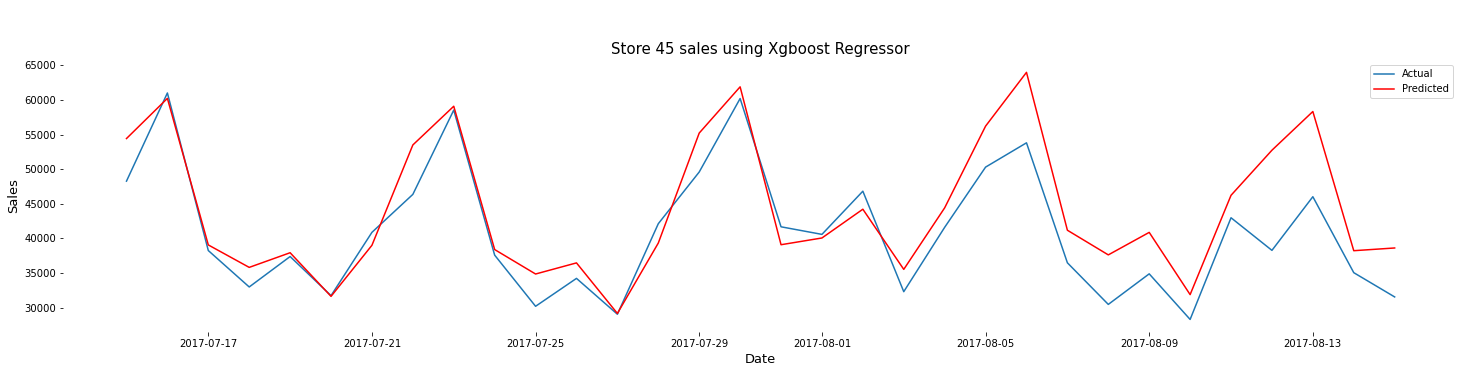

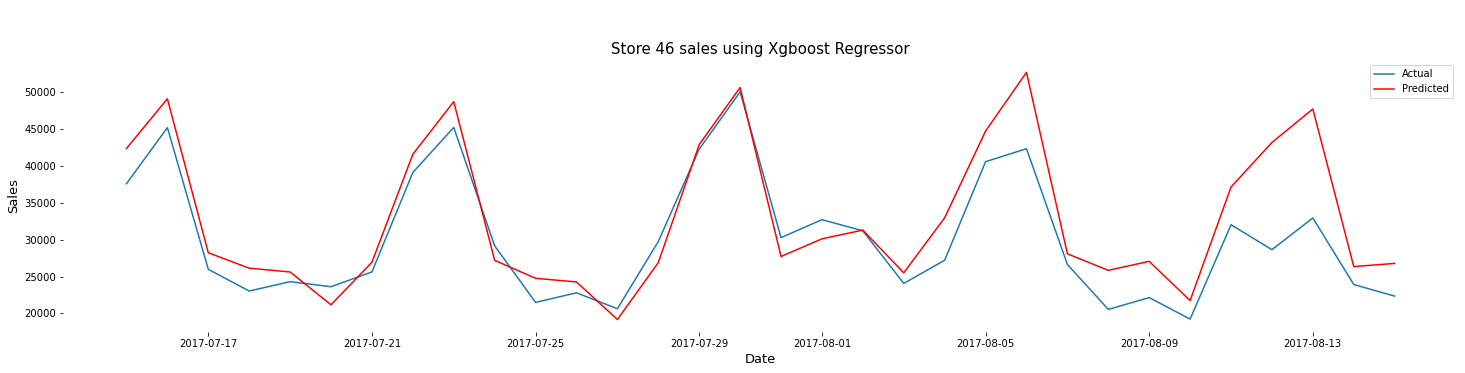

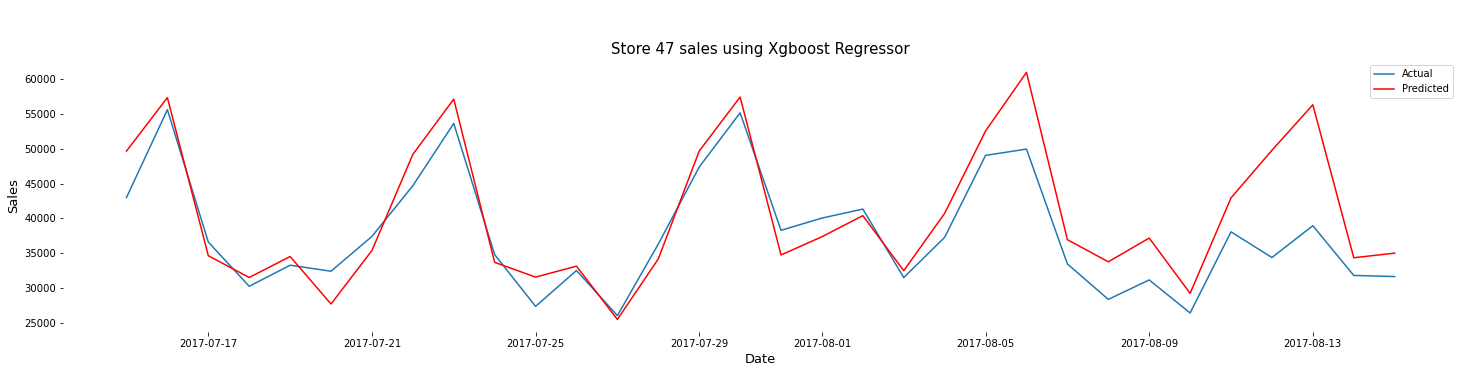

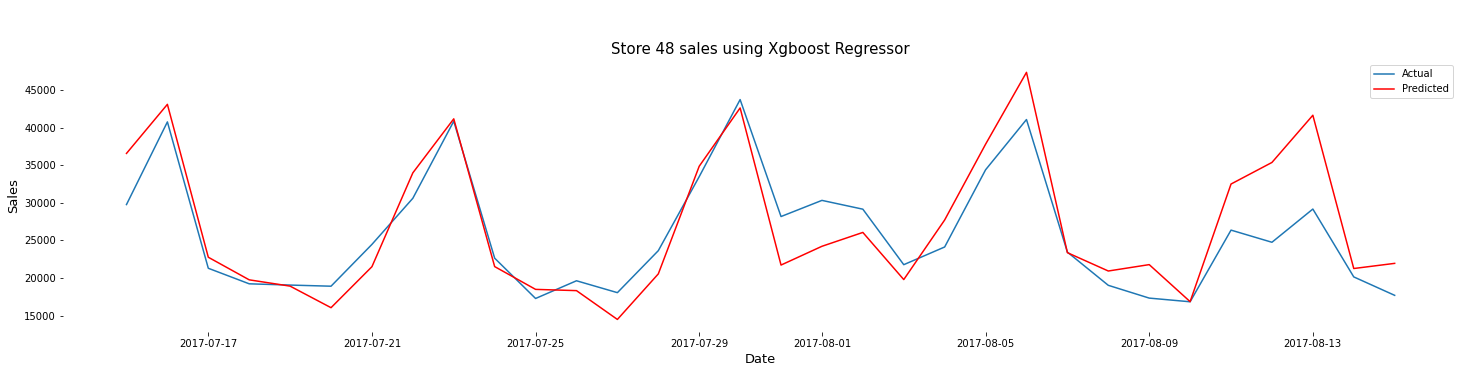

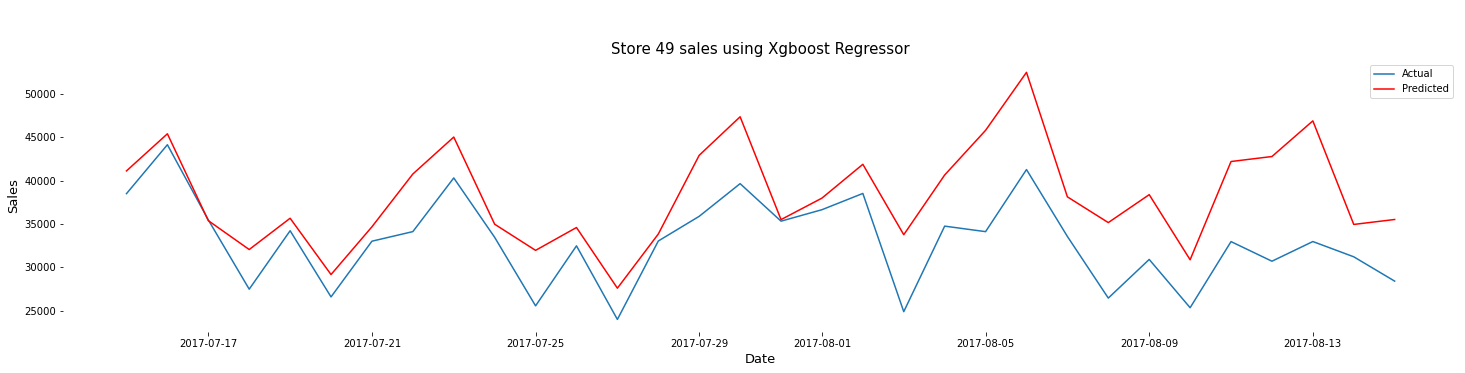

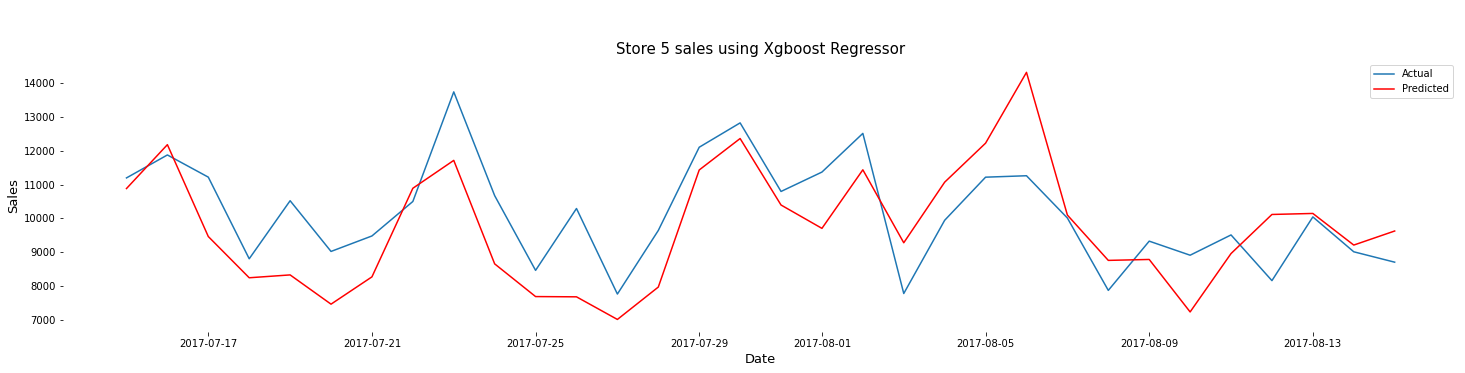

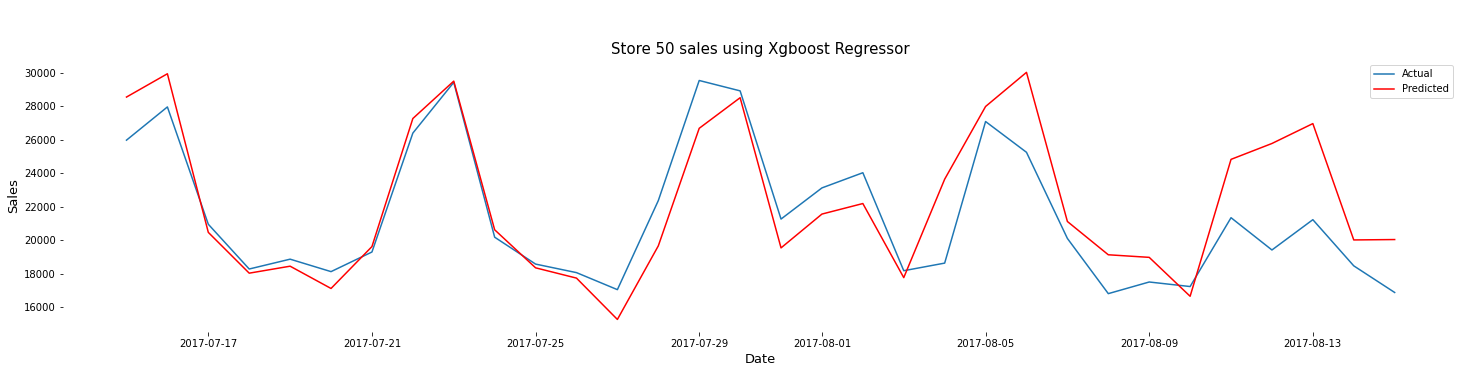

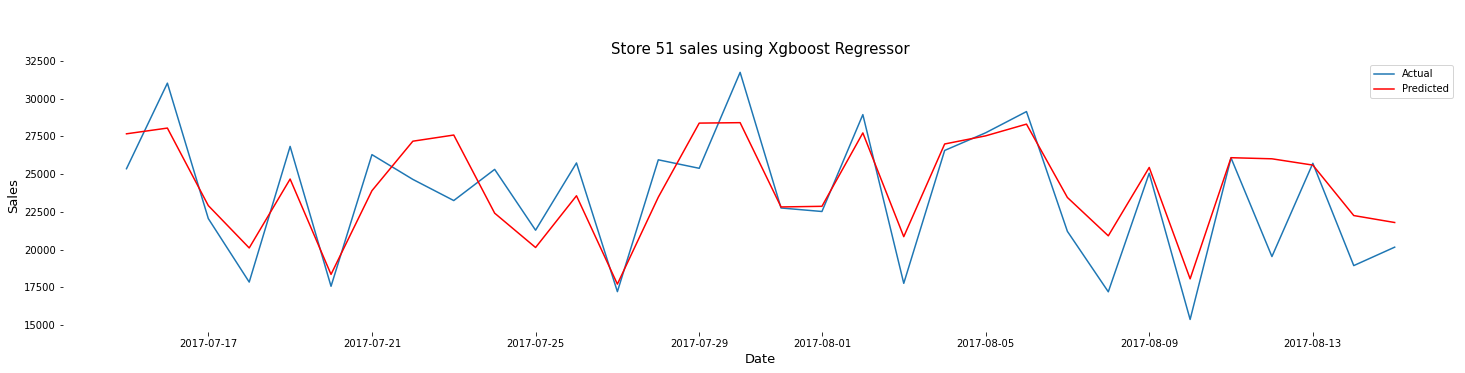

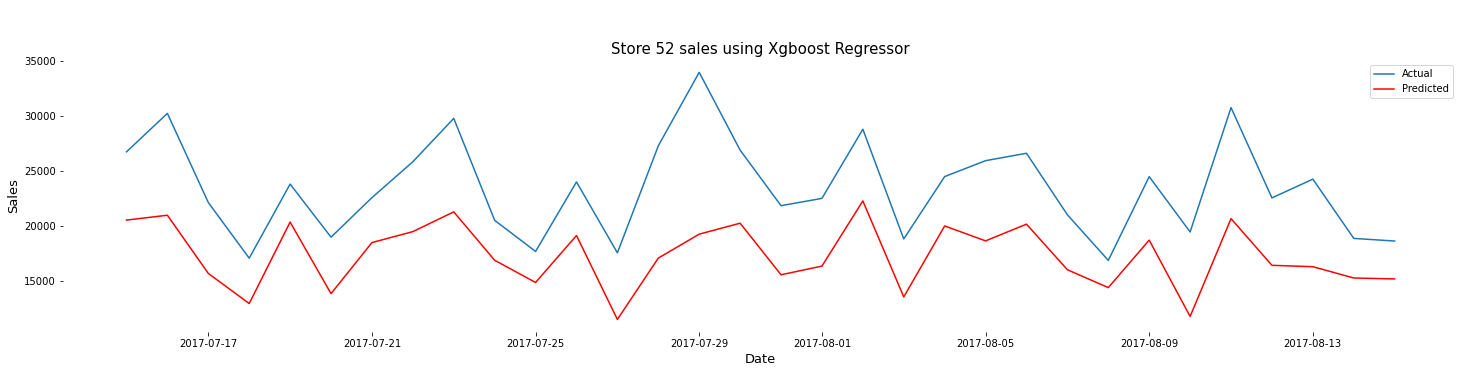

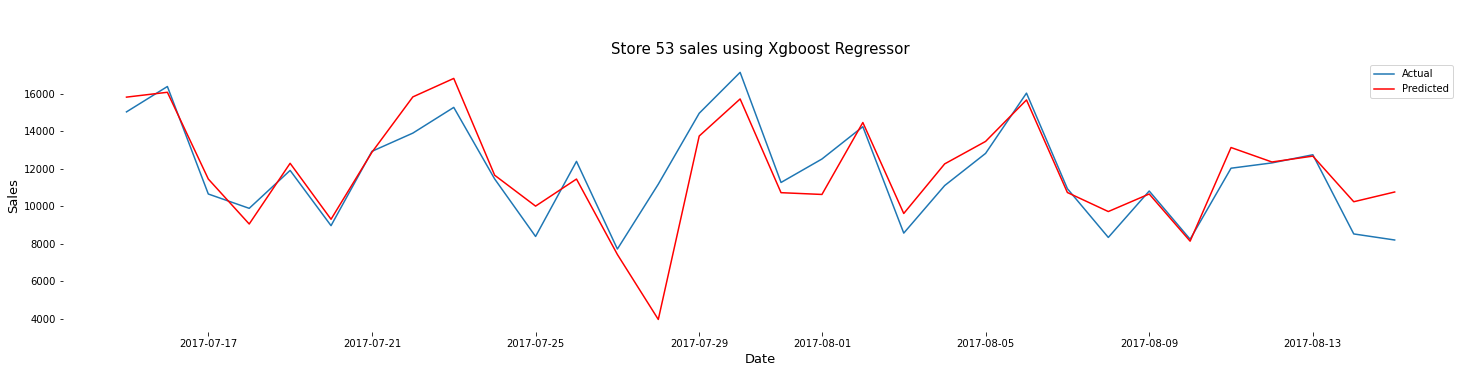

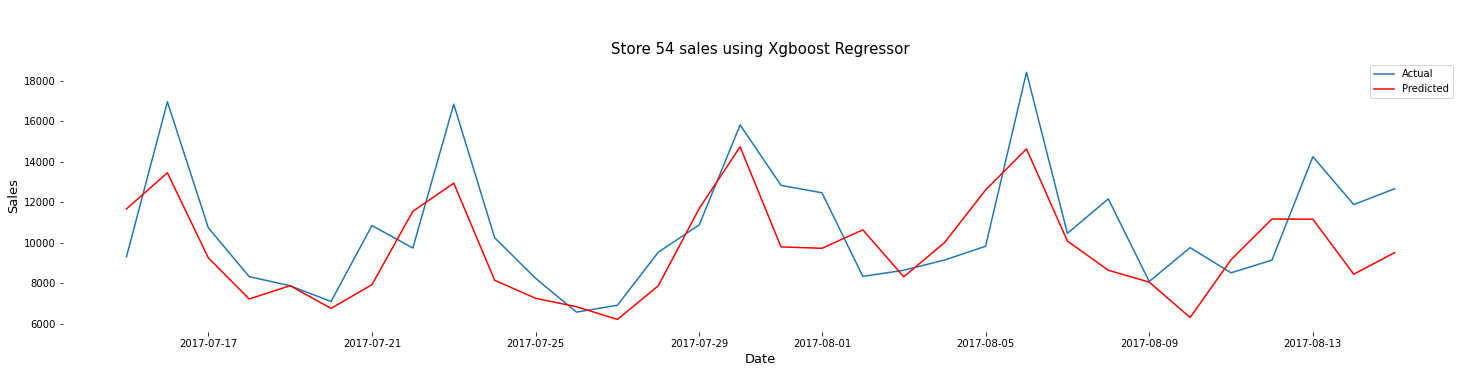

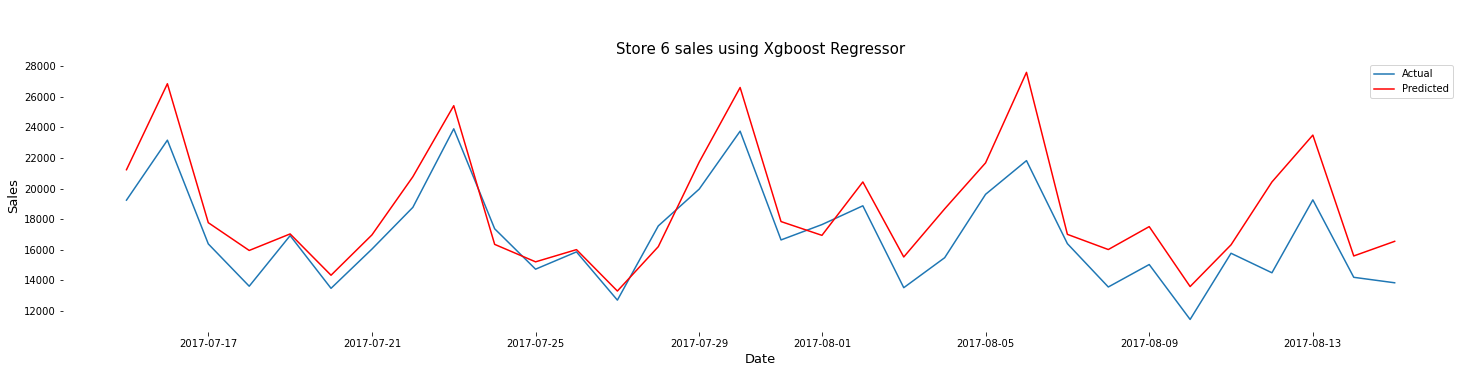

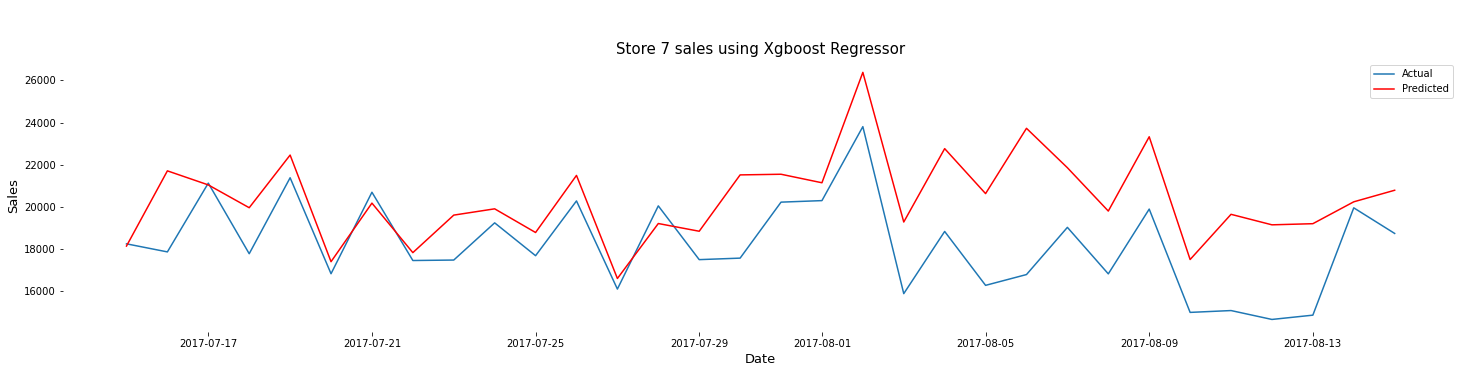

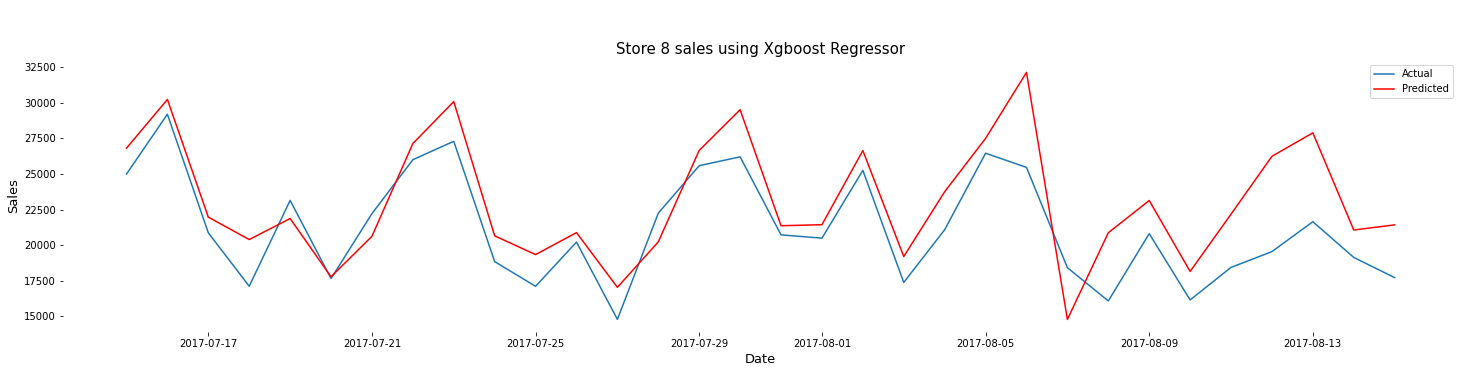

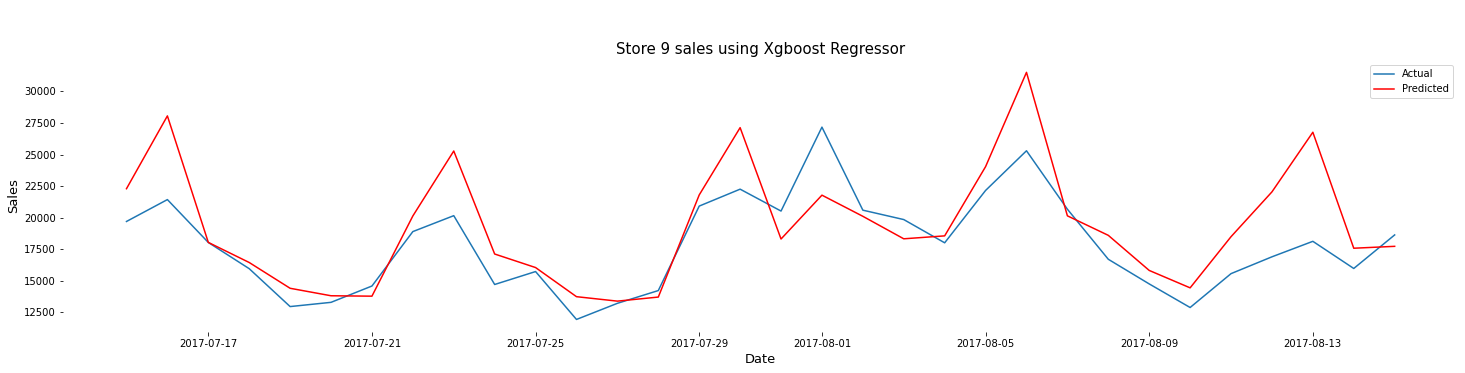

In [89]:
def plot_store_sales_predicted(testing):
    testing_with_pred = testing.copy()
    testing_with_pred["sales_pred"] = y_pred_xgbR

    for no in training["store_nbr"].unique():

        store = testing_with_pred[testing_with_pred["store_nbr"] == no].loc[:,["date","sales","sales_pred"]].copy()
        store = store.groupby("date").sum().copy()

        plt.figure(figsize=(25,5))
        act = plt.plot(store.index, store["sales"])
        pred = plt.plot(store.index, store["sales_pred"], color="red")

        plt.xlabel("Date", size=13)
        plt.ylabel("Sales", size=13)

        plt.title(f"\n\nStore {no} sales using Xgboost Regressor", size=15)
        plt.legend(["Actual","Predicted"])
        plt.box(False)

plot_store_sales_predicted(testing.copy())